# Imports

In [1]:
import pypsa
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import xarray as xr
import statsmodels.api as sm
from scipy.fft import fft, fftfreq
import seaborn as sns
import pandas as pd 
import geopandas as gpd
import numpy as np
from math import pi
import cartopy.crs as ccrs
from pyproj import Geod

from regiondefinitions import regions_dic, links_dic
from data_import import syntheticdemand_gis, historic_demand, vre_gen_potential_atlite_granularity, region_area, check_pickle,vre_gen_potential_atlite_granularity_2
from interconnectors import efficiency_link, calculate_distance

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.")

# User input

In [2]:
# Parameter selection input 
scenario_year = 2050
era_year = 2023
density = {}
density['wind'] = 10 # W/m2
density['pv'] = 45 # W/m2
land_use_availability = {}
land_use_availability['wind'] = 0.08
land_use_availability['pv'] = 0.05
SSP_scenario = 'ssp1-26'
granularity = 2

# Parameter selection grid
costs = {}
costs['capacity_wind'] = 1
costs['capacity_pv'] = 1
costs['generation_wind'] = 100
costs['generation_pv'] = 100
costs['transmission'] = 1e-4
costs['curtailment'] = 0

# Cable selection
cable_capacity = 1200 # MW
cable_voltage = 1100 # kV
cable_resistivity = 0.01286 # ohms/km
converter_losses = 0.015 # [-]

# DATA PATHS
synthetic_demand_path = "/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand"
historic_demand_path = '/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_europe_node_9_utc.csv'
output_path_figures = '/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py'
atlitepath = '/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/supply'

# COLOUR PALETTE
unique_regions = list(regions_dic.keys())
base_palette = sns.color_palette("Set2", 8)
extended_palette = base_palette + sns.color_palette("Set3", 8)
final_palette = extended_palette[:len(unique_regions)]
region_colors = {region: color for region, color in zip(unique_regions, final_palette)}
region_colors['ups'] = sns.color_palette("colorblind")[1] 

# Plotting 
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

## Prediciton of demand time series

In [3]:
run_this_cell = True
if run_this_cell:
    # DISTANCES BETWEEN NODES
    for key, value in links_dic.items():
        value["length"] = calculate_distance(value["bus0"][1], value["bus1"][1])

    # EFFICIENCY OF INTERCONNECTORS
    for key, value in links_dic.items():
        value["efficiency"] = efficiency_link(cable_capacity, cable_voltage, cable_resistivity, value["length"]) - converter_losses

    # SYNTHETIC -> excludes Europe
    load_profile_dic = {}
    for key, value in regions_dic.items():
        load_profile_dic[key] = {}
        if key != "europe":
            load_profile_dic[key]["load"] = syntheticdemand_gis(synthetic_demand_path, key, SSP_scenario) # MW

    # HISTORIC -> includes Europe and USA
    demand_mult_ssp1_26_oecd = 1.36
    load_profile_dic["europe"]["load"] = historic_demand(historic_demand_path, 2017, demand_mult_ssp1_26_oecd)

## PyPSA --> Create the grid 

In [6]:
# Initialise the network
n = pypsa.Network() 
snapshots = pd.date_range(start=f"{scenario_year}-01-01 00:00:00", end=f"{scenario_year}-12-31 23:00:00", freq="h")
n.set_snapshots(snapshots)

# Loop over the dictionary to add the buses
for key, value in regions_dic.items():
    n.add(class_name = "Bus", name = key, carrier = "DC", x = value["coordinates"][0] , y = value["coordinates"][1]) 
    
# Loop over the dictionary to add the links 
for key, value in links_dic.items():
    n.add(class_name="Link", name=f'{value["name"]}_0', bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=costs['transmission'], p_nom_max= np.inf, p_nom_extendable=True)
    n.add(class_name="Link", name=f'{value["name"]}_1', bus0=value["bus1"][1], bus1=value["bus0"][1], efficiency=value["efficiency"] , marginal_cost=costs['transmission'], p_nom_max= np.inf, p_nom_extendable=True)


# Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
for key, value in regions_dic.items():  
    if key == 'north_america':
        n.add(class_name="Generator", name=f'curtailment_{key}', type="Curtailment", bus=key, p_nom_extendable=True, marginal_cost=costs['curtailment'], sign=-1)
        for carrier in ['wind', 'pv']:
            if carrier == 'wind':
                cf_combined, caps = vre_gen_potential_atlite_granularity(atlitepath, key, carrier, era_year, density[carrier], land_use_availability[carrier], resolution=2)
                for column in cf_combined.columns:
                    n.add(class_name="Generator", name=f'{column}', type=f"{carrier}", bus=key, p_nom_extendable=True, p_nom_max=caps[column], 
                        p_max_pu=cf_combined[column][snapshots], p_min_pu=cf_combined[column][snapshots],
                        capital_cost=costs[f'capacity_{carrier}'], marginal_cost=costs[f'generation_{carrier}'])
                del cf_combined
                del caps
                
# Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
for key, value in load_profile_dic.items():
    n.add(class_name="Load", name=f"load_{key}", bus=key, p_set=value["load"][snapshots])

m = n.optimize.create_model();
n.export_to_csv_folder('globalgrid_pypsa_network', encoding=None, export_standard_types=False)

Data loaded successfully for north_america. Number of items in dfs: 948


/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/src/data_import.py:112: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/src/data_import.py:112: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/src/data_import.py:112: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

In [ ]:
n.import_from_csv_folder('globalgrid_pypsa_network')
n.optimize(solver_name='gurobi')
network_file = "network_output_granular.nc"
n.export_to_netcdf(network_file)

ERROR:pypsa.io:Error, new components for Bus are not unique
ERROR:pypsa.io:Error, new components for Generator are not unique
ERROR:pypsa.io:Error, new components for Link are not unique
ERROR:pypsa.io:Error, new components for Load are not unique
INFO:pypsa.io:Imported network globalgrid_pypsa_network has buses, generators, links, loads
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]
INFO:linopy.io: Writing time: 82.7s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-r_9oce9y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-r_9oce9y.lp


Reading time = 30.56 seconds


INFO:gurobipy:Reading time = 30.56 seconds


obj: 23365521 rows, 11625847 columns, 52803837 nonzeros


INFO:gurobipy:obj: 23365521 rows, 11625847 columns, 52803837 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23365521 rows, 11625847 columns and 52803837 nonzeros


INFO:gurobipy:Optimize a model with 23365521 rows, 11625847 columns and 52803837 nonzeros


Model fingerprint: 0xca6a1cbe


INFO:gurobipy:Model fingerprint: 0xca6a1cbe


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-10, 1e+00]


INFO:gurobipy:  Matrix range     [2e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [6e+02, 4e+06]


INFO:gurobipy:  RHS range        [6e+02, 4e+06]


Presolve removed 6138645 rows and 2717675 columns (presolve time = 6s) ...


INFO:gurobipy:Presolve removed 6138645 rows and 2717675 columns (presolve time = 6s) ...


Presolve removed 6138645 rows and 2717675 columns (presolve time = 10s) ...


INFO:gurobipy:Presolve removed 6138645 rows and 2717675 columns (presolve time = 10s) ...


Presolve removed 14695143 rows and 2717675 columns (presolve time = 17s) ...


INFO:gurobipy:Presolve removed 14695143 rows and 2717675 columns (presolve time = 17s) ...


Presolve removed 14697468 rows and 2720000 columns (presolve time = 21s) ...


INFO:gurobipy:Presolve removed 14697468 rows and 2720000 columns (presolve time = 21s) ...


Presolve removed 21077468 rows and 9100000 columns (presolve time = 25s) ...


INFO:gurobipy:Presolve removed 21077468 rows and 9100000 columns (presolve time = 25s) ...


Presolve removed 23251641 rows and 11274173 columns (presolve time = 32s) ...


INFO:gurobipy:Presolve removed 23251641 rows and 11274173 columns (presolve time = 32s) ...


Presolve removed 23251641 rows and 11274173 columns (presolve time = 35s) ...


INFO:gurobipy:Presolve removed 23251641 rows and 11274173 columns (presolve time = 35s) ...


Presolve removed 23251641 rows and 11274173 columns


INFO:gurobipy:Presolve removed 23251641 rows and 11274173 columns


Presolve time: 35.88s


INFO:gurobipy:Presolve time: 35.88s


Presolved: 113880 rows, 351674 columns, 9257298 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 351674 columns, 9257298 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 1.00s


INFO:gurobipy:Ordering time: 1.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1274


INFO:gurobipy: Dense cols : 1274


 AA' NZ     : 8.732e+06


INFO:gurobipy: AA' NZ     : 8.732e+06


 Factor NZ  : 4.928e+07 (roughly 600 MB of memory)


INFO:gurobipy: Factor NZ  : 4.928e+07 (roughly 600 MB of memory)


 Factor Ops : 3.416e+10 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.416e+10 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.47707670e+14 -3.77730784e+13  3.47e+08 2.94e+01  2.06e+11    41s


INFO:gurobipy:   0   4.47707670e+14 -3.77730784e+13  3.47e+08 2.94e+01  2.06e+11    41s


   1   3.57404748e+14 -2.02287525e+13  3.57e+08 4.75e+02  1.21e+11    44s


INFO:gurobipy:   1   3.57404748e+14 -2.02287525e+13  3.57e+08 4.75e+02  1.21e+11    44s


   2   3.04022905e+14 -1.04573110e+13  2.85e+08 3.12e+02  8.05e+10    48s


INFO:gurobipy:   2   3.04022905e+14 -1.04573110e+13  2.85e+08 3.12e+02  8.05e+10    48s


   3   2.69169238e+14 -1.42053670e+13  2.38e+08 2.31e+02  6.04e+10    52s


INFO:gurobipy:   3   2.69169238e+14 -1.42053670e+13  2.38e+08 2.31e+02  6.04e+10    52s


   4   2.22410311e+14 -2.90085361e+13  1.74e+08 1.31e+02  3.54e+10    55s


INFO:gurobipy:   4   2.22410311e+14 -2.90085361e+13  1.74e+08 1.31e+02  3.54e+10    55s


   5   1.83420020e+14 -5.37582588e+13  1.26e+08 3.45e+02  2.63e+10    58s


INFO:gurobipy:   5   1.83420020e+14 -5.37582588e+13  1.26e+08 3.45e+02  2.63e+10    58s


   6   1.59931377e+14 -6.84261133e+13  9.85e+07 4.66e+02  2.11e+10    61s


INFO:gurobipy:   6   1.59931377e+14 -6.84261133e+13  9.85e+07 4.66e+02  2.11e+10    61s


   7   1.36828041e+14 -8.77417962e+13  7.33e+07 5.39e+02  1.57e+10    64s


INFO:gurobipy:   7   1.36828041e+14 -8.77417962e+13  7.33e+07 5.39e+02  1.57e+10    64s


   8   1.22068185e+14 -1.16423932e+14  5.80e+07 5.07e+02  9.52e+09    67s


INFO:gurobipy:   8   1.22068185e+14 -1.16423932e+14  5.80e+07 5.07e+02  9.52e+09    67s


   9   1.01448966e+14 -1.26037807e+14  3.85e+07 4.01e+02  6.72e+09    70s


INFO:gurobipy:   9   1.01448966e+14 -1.26037807e+14  3.85e+07 4.01e+02  6.72e+09    70s


  10   9.63743051e+13 -1.24284842e+14  3.40e+07 3.35e+02  5.59e+09    73s


INFO:gurobipy:  10   9.63743051e+13 -1.24284842e+14  3.40e+07 3.35e+02  5.59e+09    73s


  11   8.76001537e+13 -1.14445389e+14  2.63e+07 2.74e+02  4.20e+09    76s


INFO:gurobipy:  11   8.76001537e+13 -1.14445389e+14  2.63e+07 2.74e+02  4.20e+09    76s


  12   7.44283480e+13 -8.61369277e+13  1.54e+07 2.06e+02  2.65e+09    79s


INFO:gurobipy:  12   7.44283480e+13 -8.61369277e+13  1.54e+07 2.06e+02  2.65e+09    79s


  13   6.60635596e+13 -5.65132494e+13  9.43e+06 1.33e+02  1.40e+09    82s


INFO:gurobipy:  13   6.60635596e+13 -5.65132494e+13  9.43e+06 1.33e+02  1.40e+09    82s


  14   5.77514610e+13 -2.01855479e+13  5.03e+06 7.38e+01  5.57e+08    85s


INFO:gurobipy:  14   5.77514610e+13 -2.01855479e+13  5.03e+06 7.38e+01  5.57e+08    85s


  15   5.38098293e+13 -1.14760779e+13  4.21e+06 5.67e+01  4.18e+08    88s


INFO:gurobipy:  15   5.38098293e+13 -1.14760779e+13  4.21e+06 5.67e+01  4.18e+08    88s


  16   5.33482519e+13 -1.05777786e+13  4.12e+06 5.26e+01  3.91e+08    91s


INFO:gurobipy:  16   5.33482519e+13 -1.05777786e+13  4.12e+06 5.26e+01  3.91e+08    91s


  17   4.89154708e+13 -8.25395001e+12  3.44e+06 4.66e+01  3.38e+08    94s


INFO:gurobipy:  17   4.89154708e+13 -8.25395001e+12  3.44e+06 4.66e+01  3.38e+08    94s


  18   4.50687798e+13 -7.26791339e+12  2.83e+06 4.33e+01  3.05e+08    97s


INFO:gurobipy:  18   4.50687798e+13 -7.26791339e+12  2.83e+06 4.33e+01  3.05e+08    97s


  19   4.24586027e+13 -3.82774818e+12  2.51e+06 3.53e+01  2.50e+08   100s


INFO:gurobipy:  19   4.24586027e+13 -3.82774818e+12  2.51e+06 3.53e+01  2.50e+08   100s


  20   3.76304895e+13 -1.83042878e+10  1.91e+06 2.42e+01  1.75e+08   103s


INFO:gurobipy:  20   3.76304895e+13 -1.83042878e+10  1.91e+06 2.42e+01  1.75e+08   103s


  21   3.39958882e+13  2.12452566e+12  1.55e+06 1.73e+01  1.30e+08   106s


INFO:gurobipy:  21   3.39958882e+13  2.12452566e+12  1.55e+06 1.73e+01  1.30e+08   106s


  22   3.11771576e+13  2.46598900e+12  1.33e+06 1.61e+01  1.17e+08   109s


INFO:gurobipy:  22   3.11771576e+13  2.46598900e+12  1.33e+06 1.61e+01  1.17e+08   109s


  23   2.74698896e+13  3.49617630e+12  1.05e+06 1.18e+01  8.85e+07   112s


INFO:gurobipy:  23   2.74698896e+13  3.49617630e+12  1.05e+06 1.18e+01  8.85e+07   112s


  24   2.38927748e+13  4.04099441e+12  8.15e+05 9.57e+00  7.03e+07   115s


INFO:gurobipy:  24   2.38927748e+13  4.04099441e+12  8.15e+05 9.57e+00  7.03e+07   115s


  25   2.08538680e+13  4.73925660e+12  6.24e+05 5.92e+00  5.01e+07   118s


INFO:gurobipy:  25   2.08538680e+13  4.73925660e+12  6.24e+05 5.92e+00  5.01e+07   118s


  26   2.02602380e+13  4.88027832e+12  5.92e+05 3.01e+00  4.10e+07   121s


INFO:gurobipy:  26   2.02602380e+13  4.88027832e+12  5.92e+05 3.01e+00  4.10e+07   121s


  27   1.77839299e+13  5.06358044e+12  4.76e+05 1.60e+00  3.11e+07   125s


INFO:gurobipy:  27   1.77839299e+13  5.06358044e+12  4.76e+05 1.60e+00  3.11e+07   125s


  28   1.50790390e+13  5.06712451e+12  3.61e+05 1.04e+00  2.35e+07   128s


INFO:gurobipy:  28   1.50790390e+13  5.06712451e+12  3.61e+05 1.04e+00  2.35e+07   128s


  29   1.06292607e+13  5.16468237e+12  1.74e+05 5.00e-01  1.23e+07   131s


INFO:gurobipy:  29   1.06292607e+13  5.16468237e+12  1.74e+05 5.00e-01  1.23e+07   131s


  30   9.95505772e+12  5.18218910e+12  1.50e+05 4.71e-01  1.07e+07   134s


INFO:gurobipy:  30   9.95505772e+12  5.18218910e+12  1.50e+05 4.71e-01  1.07e+07   134s


  31   9.16707475e+12  5.28915083e+12  1.24e+05 2.85e-01  8.51e+06   137s


INFO:gurobipy:  31   9.16707475e+12  5.28915083e+12  1.24e+05 2.85e-01  8.51e+06   137s


  32   8.61216258e+12  5.37483024e+12  1.05e+05 1.74e-01  7.01e+06   140s


INFO:gurobipy:  32   8.61216258e+12  5.37483024e+12  1.05e+05 1.74e-01  7.01e+06   140s


  33   7.65827831e+12  5.43647713e+12  7.22e+04 1.24e-01  4.79e+06   143s


INFO:gurobipy:  33   7.65827831e+12  5.43647713e+12  7.22e+04 1.24e-01  4.79e+06   143s


  34   7.15549447e+12  5.52092582e+12  5.32e+04 8.36e-02  3.51e+06   146s


INFO:gurobipy:  34   7.15549447e+12  5.52092582e+12  5.32e+04 8.36e-02  3.51e+06   146s


  35   7.00841837e+12  5.59503913e+12  4.71e+04 6.33e-02  3.02e+06   149s


INFO:gurobipy:  35   7.00841837e+12  5.59503913e+12  4.71e+04 6.33e-02  3.02e+06   149s


  36   6.76989329e+12  5.63501218e+12  3.74e+04 5.47e-02  2.43e+06   152s


INFO:gurobipy:  36   6.76989329e+12  5.63501218e+12  3.74e+04 5.47e-02  2.43e+06   152s


  37   6.69073452e+12  5.68500174e+12  3.38e+04 4.85e-02  2.15e+06   155s


INFO:gurobipy:  37   6.69073452e+12  5.68500174e+12  3.38e+04 4.85e-02  2.15e+06   155s


  38   6.66167535e+12  5.72370551e+12  3.23e+04 4.40e-02  2.00e+06   159s


INFO:gurobipy:  38   6.66167535e+12  5.72370551e+12  3.23e+04 4.40e-02  2.00e+06   159s


  39   6.57601086e+12  5.75498590e+12  2.70e+04 4.07e-02  1.75e+06   162s


INFO:gurobipy:  39   6.57601086e+12  5.75498590e+12  2.70e+04 4.07e-02  1.75e+06   162s


  40   6.56388102e+12  5.80978585e+12  2.61e+04 3.55e-02  1.61e+06   166s


INFO:gurobipy:  40   6.56388102e+12  5.80978585e+12  2.61e+04 3.55e-02  1.61e+06   166s


  41   6.52676050e+12  5.88769838e+12  2.30e+04 2.82e-02  1.36e+06   169s


INFO:gurobipy:  41   6.52676050e+12  5.88769838e+12  2.30e+04 2.82e-02  1.36e+06   169s


  42   6.50668474e+12  5.92542967e+12  2.11e+04 2.34e-02  1.24e+06   173s


INFO:gurobipy:  42   6.50668474e+12  5.92542967e+12  2.11e+04 2.34e-02  1.24e+06   173s


  43   6.49506986e+12  5.98835070e+12  2.00e+04 1.87e-02  1.08e+06   177s


INFO:gurobipy:  43   6.49506986e+12  5.98835070e+12  2.00e+04 1.87e-02  1.08e+06   177s


  44   6.47976188e+12  6.01894179e+12  1.84e+04 1.60e-02  9.81e+05   180s


INFO:gurobipy:  44   6.47976188e+12  6.01894179e+12  1.84e+04 1.60e-02  9.81e+05   180s


  45   6.47480827e+12  6.03282924e+12  1.78e+04 1.30e-02  9.41e+05   184s


INFO:gurobipy:  45   6.47480827e+12  6.03282924e+12  1.78e+04 1.30e-02  9.41e+05   184s


  46   6.44324907e+12  6.08622447e+12  1.40e+04 9.60e-03  7.61e+05   187s


INFO:gurobipy:  46   6.44324907e+12  6.08622447e+12  1.40e+04 9.60e-03  7.61e+05   187s


  47   6.43827088e+12  6.10400385e+12  1.31e+04 8.98e-03  7.12e+05   191s


INFO:gurobipy:  47   6.43827088e+12  6.10400385e+12  1.31e+04 8.98e-03  7.12e+05   191s


  48   6.43010444e+12  6.14692833e+12  1.16e+04 8.89e-03  6.03e+05   194s


INFO:gurobipy:  48   6.43010444e+12  6.14692833e+12  1.16e+04 8.89e-03  6.03e+05   194s


  49   6.41795050e+12  6.17351797e+12  9.42e+03 8.85e-03  5.21e+05   198s


INFO:gurobipy:  49   6.41795050e+12  6.17351797e+12  9.42e+03 8.85e-03  5.21e+05   198s


  50   6.40882556e+12  6.19630402e+12  7.31e+03 7.71e-03  4.54e+05   201s


INFO:gurobipy:  50   6.40882556e+12  6.19630402e+12  7.31e+03 7.71e-03  4.54e+05   201s


  51   6.40706154e+12  6.21947050e+12  6.84e+03 6.87e-03  4.00e+05   205s


INFO:gurobipy:  51   6.40706154e+12  6.21947050e+12  6.84e+03 6.87e-03  4.00e+05   205s


  52   6.40367090e+12  6.24768344e+12  5.64e+03 5.62e-03  3.33e+05   208s


INFO:gurobipy:  52   6.40367090e+12  6.24768344e+12  5.64e+03 5.62e-03  3.33e+05   208s


  53   6.40125096e+12  6.27025358e+12  4.76e+03 4.48e-03  2.80e+05   212s


INFO:gurobipy:  53   6.40125096e+12  6.27025358e+12  4.76e+03 4.48e-03  2.80e+05   212s


  54   6.40056700e+12  6.27545807e+12  4.50e+03 4.26e-03  2.67e+05   215s


INFO:gurobipy:  54   6.40056700e+12  6.27545807e+12  4.50e+03 4.26e-03  2.67e+05   215s


  55   6.39769452e+12  6.30156784e+12  3.39e+03 3.17e-03  2.05e+05   219s


INFO:gurobipy:  55   6.39769452e+12  6.30156784e+12  3.39e+03 3.17e-03  2.05e+05   219s


  56   6.39618044e+12  6.31574581e+12  2.74e+03 2.62e-03  1.72e+05   224s


INFO:gurobipy:  56   6.39618044e+12  6.31574581e+12  2.74e+03 2.62e-03  1.72e+05   224s


  57   6.39508486e+12  6.33686776e+12  2.16e+03 1.81e-03  1.24e+05   228s


INFO:gurobipy:  57   6.39508486e+12  6.33686776e+12  2.16e+03 1.81e-03  1.24e+05   228s


  58   6.39414977e+12  6.35057752e+12  1.71e+03 1.31e-03  9.29e+04   232s


INFO:gurobipy:  58   6.39414977e+12  6.35057752e+12  1.71e+03 1.31e-03  9.29e+04   232s


  59   6.39411046e+12  6.35186182e+12  1.68e+03 1.27e-03  9.01e+04   236s


INFO:gurobipy:  59   6.39411046e+12  6.35186182e+12  1.68e+03 1.27e-03  9.01e+04   236s


  60   6.39288405e+12  6.36902681e+12  8.61e+02 6.35e-04  5.09e+04   239s


INFO:gurobipy:  60   6.39288405e+12  6.36902681e+12  8.61e+02 6.35e-04  5.09e+04   239s


  61   6.39204493e+12  6.37811361e+12  3.32e+02 3.47e-04  2.99e+04   243s


INFO:gurobipy:  61   6.39204493e+12  6.37811361e+12  3.32e+02 3.47e-04  2.99e+04   243s


  62   6.39171926e+12  6.38428322e+12  1.53e+02 1.86e-04  1.60e+04   246s


INFO:gurobipy:  62   6.39171926e+12  6.38428322e+12  1.53e+02 1.86e-04  1.60e+04   246s


  63   6.39156179e+12  6.38693227e+12  6.95e+01 1.00e-04  9.97e+03   250s


INFO:gurobipy:  63   6.39156179e+12  6.38693227e+12  6.95e+01 1.00e-04  9.97e+03   250s


  64   6.39151533e+12  6.38829791e+12  4.16e+01 6.14e-05  6.93e+03   253s


INFO:gurobipy:  64   6.39151533e+12  6.38829791e+12  4.16e+01 6.14e-05  6.93e+03   253s


  65   6.39147908e+12  6.39028965e+12  1.94e+01 1.73e-05  2.56e+03   256s


INFO:gurobipy:  65   6.39147908e+12  6.39028965e+12  1.94e+01 1.73e-05  2.56e+03   256s


  66   6.39144870e+12  6.39089036e+12  2.42e+00 8.20e-06  1.21e+03   260s


INFO:gurobipy:  66   6.39144870e+12  6.39089036e+12  2.42e+00 8.20e-06  1.21e+03   260s


  67   6.39144491e+12  6.39135815e+12  4.88e-01 1.48e-06  1.85e+02   264s


INFO:gurobipy:  67   6.39144491e+12  6.39135815e+12  4.88e-01 1.48e-06  1.85e+02   264s


  68   6.39144370e+12  6.39141376e+12  9.20e-02 3.55e-06  5.72e+01   267s


INFO:gurobipy:  68   6.39144370e+12  6.39141376e+12  9.20e-02 3.55e-06  5.72e+01   267s


  69   6.39144222e+12  6.39143004e+12  2.81e-03 1.67e-05  1.06e+01   271s


INFO:gurobipy:  69   6.39144222e+12  6.39143004e+12  2.81e-03 1.67e-05  1.06e+01   271s


  70   6.39144120e+12  6.39143182e+12  1.00e-04 8.28e-06  2.93e+00   275s


INFO:gurobipy:  70   6.39144120e+12  6.39143182e+12  1.00e-04 8.28e-06  2.93e+00   275s


  71   6.39144067e+12  6.39143241e+12  1.66e-05 5.88e-06  6.34e-01   279s


INFO:gurobipy:  71   6.39144067e+12  6.39143241e+12  1.66e-05 5.88e-06  6.34e-01   279s


  72   6.39144035e+12  6.39143272e+12  4.07e-06 5.72e-06  1.53e-01   284s


INFO:gurobipy:  72   6.39144035e+12  6.39143272e+12  4.07e-06 5.72e-06  1.53e-01   284s


  73   6.39144018e+12  6.39143293e+12  2.17e-06 5.53e-06  7.23e-02   288s


INFO:gurobipy:  73   6.39144018e+12  6.39143293e+12  2.17e-06 5.53e-06  7.23e-02   288s


  74   6.39144009e+12  6.39143304e+12  1.55e-06 5.49e-06  4.68e-02   292s


INFO:gurobipy:  74   6.39144009e+12  6.39143304e+12  1.55e-06 5.49e-06  4.68e-02   292s


INFO:gurobipy:


Barrier solved model in 74 iterations and 292.11 seconds (137.73 work units)


INFO:gurobipy:Barrier solved model in 74 iterations and 292.11 seconds (137.73 work units)


Optimal objective 6.39144009e+12


INFO:gurobipy:Optimal objective 6.39144009e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   12129 DPushes remaining with DInf 0.0000000e+00               293s


INFO:gurobipy:   12129 DPushes remaining with DInf 0.0000000e+00               293s


       0 DPushes remaining with DInf 0.0000000e+00               293s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               293s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  290322 PPushes remaining with PInf 5.0331843e+00               293s


INFO:gurobipy:  290322 PPushes remaining with PInf 5.0331843e+00               293s


  165679 PPushes remaining with PInf 3.0971533e+00               295s


INFO:gurobipy:  165679 PPushes remaining with PInf 3.0971533e+00               295s


   30709 PPushes remaining with PInf 6.6482601e-02               301s


INFO:gurobipy:   30709 PPushes remaining with PInf 6.6482601e-02               301s


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  196682    6.3914360e+12   0.000000e+00   0.000000e+00    325s


INFO:gurobipy:  196682    6.3914360e+12   0.000000e+00   0.000000e+00    325s


INFO:gurobipy:


Solved in 196682 iterations and 324.98 seconds (547.65 work units)


INFO:gurobipy:Solved in 196682 iterations and 324.98 seconds (547.65 work units)


Optimal objective  6.391436009e+12


INFO:gurobipy:Optimal objective  6.391436009e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11625847 primals, 23365521 duals
Objective: 6.39e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:pypsa.io:Exported network network_output_granular.h5 has links, generators, buses, loads


<xarray.Dataset> Size: 213MB
Dimensions:                       (snapshots: 8760, investment_periods: 0,
                                   links_i: 40, links_t_p0_i: 26,
                                   links_t_p1_i: 26, generators_i: 1287,
                                   generators_t_p_min_pu_i: 1274,
                                   generators_t_p_max_pu_i: 1274,
                                   generators_t_p_i: 385, buses_i: 13,
                                   buses_t_p_i: 13,
                                   buses_t_marginal_price_i: 13, loads_i: 13,
                                   loads_t_p_set_i: 13, loads_t_p_i: 13)
Coordinates: (12/15)
  * snapshots                     (snapshots) int64 70kB 0 1 2 ... 8758 8759
  * investment_periods            (investment_periods) object 0B 
  * links_i                       (links_i) object 320B 'north_america_to_lat...
  * links_t_p0_i                  (links_t_p0_i) object 208B 'north_america_t...
  * links_t_p1_i                  (links_t_p1_i) object 208B 'north_america_t...
  * generators_i                  (generators_i) object 10kB 'curtailment_nor...
    ...                            ...
  * buses_i                       (buses_i) object 104B 'north_america' ... '...
  * buses_t_p_i                   (buses_t_p_i) object 104B 'north_america' ....
  * buses_t_marginal_price_i      (buses_t_marginal_price_i) object 104B 'nor...
  * loads_i                       (loads_i) object 104B 'load_north_america' ...
  * loads_t_p_set_i               (loads_t_p_set_i) object 104B 'load_north_a...
  * loads_t_p_i                   (loads_t_p_i) object 104B 'load_north_ameri...
Data variables: (12/34)
    snapshots_snapshot            (snapshots) datetime64[ns] 70kB 2050-01-01 ...
    snapshots_objective           (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_generators          (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_stores              (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    investment_periods_objective  (investment_periods) object 0B 
    investment_periods_years      (investment_periods) object 0B 
    ...                            ...
    buses_carrier                 (buses_i) object 104B 'DC' 'DC' ... 'DC' 'DC'
    buses_t_p                     (snapshots, buses_t_p_i) float64 911kB 3.81...
    buses_t_marginal_price        (snapshots, buses_t_marginal_price_i) float64 911kB ...
    loads_bus                     (loads_i) object 104B 'north_america' ... '...
    loads_t_p_set                 (snapshots, loads_t_p_set_i) float64 911kB ...
    loads_t_p                     (snapshots, loads_t_p_i) float64 911kB 9.67...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                nan
    network_objective:           6391436009206.163
    network_objective_constant:  0.0
    network_pypsa_version:       0.28.0
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

# **ANALYSIS OF GLOBAL GRID**

## Caluclate installed capacity, generation, curtailment and demand for each region

In [ ]:
for key, value in regions_dic.items(): # Annual (total) values
    for carrier in ["pv", "wind"]: 
        res_generators = n.generators[(n.generators['bus'] == key) & (n.generators['type'] == carrier)].index
        regions_dic[key][f"{carrier}_installed"] = n.generators.p_nom_opt[res_generators].sum() * 1e-3 # GW; Installed capacities for each node 
        print(key, carrier, regions_dic[key][f"{carrier}_installed"],'GW')
        regions_dic[key][f"total_{carrier}_yearly"] = n.generators_t.p[res_generators].sum(axis=1).sum(axis=0) * 1e-3 # GWh; Total energy generated at each node 
        print(key, carrier, regions_dic[key][f"total_{carrier}_yearly"]*1e-3,'TWh')
    regions_dic[key][f"total_curtailment_yearly"] = n.generators_t.p[f"curtailment_{key}"].sum(axis=0) * 1e-3 # GWh; Curtailment at each node 
    regions_dic[key][f"total_load_yearly"] = n.loads_t.p[f"load_{key}"].sum(axis=0) * 1e-3 # GWh

north_america pv 1979.5596144616948 GW
north_america pv 2796.951983213416 TWh
north_america wind 3507.366276661831 GW
north_america wind 6506.13102992933 TWh
latin_america pv 1224.8524263828406 GW
latin_america pv 1699.948327082498 TWh
latin_america wind 3167.036425251428 GW
latin_america wind 3286.8229225715163 TWh
oceania pv 2000.1988379383736 GW
oceania pv 2835.9453439478198 TWh
oceania wind 3181.1108074200192 GW
oceania wind 6176.028599742307 TWh
north_asia pv 474.000811866712 GW
north_asia pv 634.7126806408585 TWh
north_asia wind 3450.3964782363846 GW
north_asia wind 3701.6078339947344 TWh
south_asia pv 0.0 GW
south_asia pv 0.0 TWh
south_asia wind 3834.8402141591905 GW
south_asia wind 695.9573073865241 TWh
north_west_asia pv 1595.365070961487 GW
north_west_asia pv 2277.1535429893906 TWh
north_west_asia wind 1065.31392010658 GW
north_west_asia wind 1512.5153723711971 TWh
south_west_asia pv 0.0 GW
south_west_asia pv 0.0 TWh
south_west_asia wind 2029.4273948567843 GW
south_west_asia 

## Calculate hourly time series of generation, curtailment, and load

In [ ]:
# Sum generation and loads of nodes
total_hourly_gen = pd.Series(0, index=n.snapshots)
total_hourly_wind = pd.Series(0, index=n.snapshots)
total_hourly_pv = pd.Series(0, index=n.snapshots)
total_hourly_cur = pd.Series(0, index=n.snapshots)
total_hourly_load = pd.Series(0, index=n.snapshots)
for key, value in regions_dic.items():
    res_generators = n.generators[(n.generators['bus'] == key) & (n.generators['type'].isin(["pv", "wind"]))]
    wind_generators = n.generators[(n.generators['bus'] == key) & (n.generators['type'].isin(["wind"]))]
    wind_generators_ids = wind_generators.index
    pv_generators = n.generators[(n.generators['bus'] == key) & (n.generators['type'].isin(["pv"]))]
    pv_generators_ids = pv_generators.index
    res_generator_ids = res_generators.index
    total_hourly_gen += n.generators_t.p[res_generator_ids].sum(axis=1)
    total_hourly_wind += n.generators_t.p[wind_generators_ids].sum(axis=1)
    total_hourly_pv += n.generators_t.p[pv_generators_ids].sum(axis=1)
    total_hourly_cur += n.generators_t.p[f"curtailment_{key}"]
    total_hourly_load += n.loads_t.p[f"load_{key}"]
    
# Generation total
total_daily_gen = total_hourly_gen.groupby(total_hourly_gen.index.date).sum()
total_weekly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('W')).sum()
total_monthly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('M')).sum()
total_annual_gen = total_hourly_gen.sum()

# Generation wind
total_daily_wind = total_hourly_wind.groupby(total_hourly_wind.index.date).sum()
total_monthly_wind = total_hourly_wind.groupby(total_hourly_wind.index.to_period('M')).sum()
total_annual_wind = total_hourly_wind.sum()

# Generation pv
total_daily_pv = total_hourly_pv.groupby(total_hourly_pv.index.date).sum()
total_monthly_pv = total_hourly_pv.groupby(total_hourly_pv.index.to_period('M')).sum()
total_annual_pv = total_hourly_pv.sum()

# Curtailment
total_daily_cur = total_hourly_cur.groupby(total_hourly_cur.index.date).sum()
total_monthly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('M')).sum()
total_annual_cur = total_hourly_cur.sum()

# Curtailment std and mean
mean_monthly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('M')).mean()
std_monthly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('M')).std()

# Load 
total_daily_load = total_hourly_load.groupby(total_hourly_load.index.date).sum()
total_monthly_load = total_hourly_load.groupby(total_hourly_load.index.to_period('M')).sum()
total_annual_load = total_hourly_load.sum()

## Calculate global relative transmission, curtailment, and losses  

In [ ]:
# Store hourly losses for each link in dictionary
for key, value in links_dic.items():
    p0_0, p1_0 = n.links_t.p0[f'{value["name"]}_0'], n.links_t.p1[f'{value["name"]}_0']
    p0_1, p1_1 = n.links_t.p0[f'{value["name"]}_1'], n.links_t.p1[f'{value["name"]}_1']
    abs_losses = abs(p0_0 + p1_0) + abs(p0_1 + p1_1)
    p_trans = p0_0 + p0_1
    value["hourly_p_trans"] = p_trans
    value["hourly_abs_losses"] = abs_losses

# Sum the transmission and losses of the links
total_hourly_abs_losses = pd.Series(0, index=n.snapshots)
total_hourly_p_trans = pd.Series(0, index=n.snapshots)
for key, value in links_dic.items():
    total_hourly_abs_losses += value["hourly_abs_losses"]
    total_hourly_p_trans += value["hourly_p_trans"]

# Absolute losses
total_daily_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.date).sum()
total_monthly_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).sum()
total_annual_abs_losses = total_hourly_abs_losses.sum()

# Losses std and mean 
total_monthly_losses_std = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).std()
total_monthly_losses_mean = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).mean()

# Power transmitted
total_daily_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum()
total_monthly_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum()
total_annual_p_trans = total_hourly_p_trans.sum()

# Relative losses to transmission
daily_rel_losses = total_daily_abs_losses / total_daily_p_trans
monthly_rel_losses = total_monthly_abs_losses / total_monthly_p_trans
annual_rel_losses = total_annual_abs_losses / total_annual_p_trans

# Statistics of the losses to transmission
mean_losses = total_hourly_abs_losses.mean()
std_losses = total_hourly_abs_losses.std()
daily_deviation = daily_rel_losses - daily_rel_losses.mean()
monthly_deviation = monthly_rel_losses - monthly_rel_losses.mean()

# Losses relative to load
hourly_losses_rel_to_load = total_hourly_abs_losses / total_hourly_load
daily_losses_rel_to_load = total_daily_abs_losses / total_daily_load
monthly_losses_rel_to_load = total_monthly_abs_losses / total_monthly_load
annual_losses_rel_to_load = total_annual_abs_losses / total_annual_load

# Losses relative to gen
hourly_losses_rel_to_gen = total_hourly_abs_losses / total_hourly_gen
daily_losses_rel_to_gen = total_daily_abs_losses / total_daily_gen
monthly_losses_rel_to_gen = total_monthly_abs_losses / total_monthly_gen
annual_losses_rel_to_gen = total_annual_abs_losses / total_annual_gen

# Curtailment relative to gen
hourly_cur_rel_to_gen = total_hourly_cur / total_hourly_gen
daily_cur_rel_to_gen = total_daily_cur / total_daily_gen
monthly_cur_rel_to_gen = total_monthly_cur / total_monthly_gen
annual_cur_rel_to_gen = total_annual_cur / total_annual_gen

# Curtailment relative to load
hourly_cur_rel_to_load = total_hourly_cur / total_hourly_load
daily_cur_rel_to_load = total_daily_cur / total_daily_load
monthly_cur_rel_to_load = total_monthly_cur / total_monthly_load
annual_cur_rel_to_load = total_annual_cur / total_annual_load

# Power transmitted rel to gen
hourly_p_trans_rel_gen = total_hourly_p_trans / total_hourly_gen
daily_p_trans_rel_gen = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum() / total_daily_gen
monthly_p_trans_rel_gen = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum() / total_monthly_gen
annual_p_trans_rel_gen = total_hourly_p_trans.sum() / total_annual_gen

# Power transmitted rel to load
hourly_p_trans_rel_load= total_hourly_p_trans / total_hourly_load
daily_p_trans_rel_load = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum() / total_daily_load
monthly_p_trans_rel_load = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum() / total_monthly_load
annual_p_trans_rel_load = total_hourly_p_trans.sum() / total_annual_load

## Calculate inflows, outflows, and net flows for each region

In [ ]:
# Calculate inflow, outflow, and 
for region_key, region_value in regions_dic.items():
    inflow = 0
    outflow = 0
    inflow_series = pd.Series(0, index=n.snapshots)
    outflow_series = pd.Series(0, index=n.snapshots)
    for link_key, link_value in links_dic.items():
        if region_value["bus"] == link_value["bus0"][0]: 
            p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
            p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
            sum_p0_0 = abs(sum(p0_0))
            sum_p1_1 = abs(sum(p1_1))
            outflow += sum_p0_0
            inflow += sum_p1_1
            outflow_series += p0_0.abs()
            inflow_series += p1_1.abs()
        elif region_value["bus"] == link_value["bus1"][0]:
            p0_1 = n.links_t.p0[f"{link_value["name"]}_1"]
            p1_0 = n.links_t.p1[f"{link_value["name"]}_0"]
            sum_p0_1 = sum(p0_1.abs())
            sum_p1_0 = sum(p1_0.abs())
            outflow += sum_p0_1
            inflow += sum_p1_0
            outflow_series += p0_1.abs()
            inflow_series += p1_0.abs()
    netflow = (outflow - inflow) 
    netflow_series = (outflow_series - inflow_series) 
    region_value["inflow"] = inflow * 1e-3 # GW
    region_value["outflow"] = outflow * 1e-3 # GW
    region_value["inflow_series"] = inflow_series * 1e-3 # GW
    region_value["outflow_series"] = outflow_series * 1e-3 # GW
    region_value["netflow"] = netflow * 1e-3 # GW
    region_value["netflow_series"] = netflow_series * 1e-3 # GW
    region_value["actualflow"] = (outflow_series.abs() - inflow_series.abs()) * 1e-3 # GW
    region_value["actualflow"] = np.where(region_value["actualflow"] < 0, 0, region_value["actualflow"])
    region_value['total_actualflow'] = region_value["actualflow"].sum()



In [ ]:
# Compute total power transmitted for each hour
total_actual_flow = pd.Series(0, index=n.snapshots)
total_actual_flow_int = 0
for key, value in regions_dic.items():
    total_actual_flow += value["actualflow"]
    total_actual_flow_int += value["total_actualflow"]

# Actual flow 
hourly_actual_flow_rel_gen = total_actual_flow / total_hourly_gen

def flow_direction(date=None):
    # Compute inflow, outflow direction per link
    flow_statements = {}
    netflows_links = {}
    netflows_links_series = {}
    for link_key, link_value in links_dic.items():
        if date == None:
            p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
            p0_1 = n.links_t.p0[f"{link_value["name"]}_1"]
            p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
            sum_p0_0 = abs(sum(p0_0))
            sum_p0_1 = abs(sum(p1_1))
            netflows_links[link_key] = abs(sum_p0_0 - sum_p0_1)
            netflows_links_series[link_key] = (p0_0 - p0_1) * 1e-3 #GW
            if sum_p0_0 > sum_p0_1:
                flow_statements[link_key] = True # outflow
            else:
                flow_statements[link_key] = False
        else:
            p0_0 = n.links_t.p0[f"{link_value["name"]}_0"][date]
            p0_1 = n.links_t.p0[f"{link_value["name"]}_1"][date]
            p1_1 = n.links_t.p1[f"{link_value["name"]}_1"][date]
            net_flow = abs(p0_0 - p0_1)
            if p0_0 > p0_1:
                flow_statements[link_key] = True # outflow
            else:
                flow_statements[link_key] = False
        
    return flow_statements, netflows_links, netflows_links_series
flow_statements = flow_direction()[0]
netflows_links = flow_direction()[1]
netflows_links_series = flow_direction()[2]

# Calculation of monthly inflows and outflows
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
month_periods = pd.period_range(start='2050-01', periods=12, freq='M')
month_to_period = {month: period for month, period in zip(months, month_periods)}
for i, month in enumerate(months):
    period = month_to_period[month]
    for region_key, region_value in regions_dic.items():
        inflow = 0
        outflow = 0
        for link_key, link_value in links_dic.items():
            if region_value["bus"] == link_value["bus0"][0]:
                p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
                p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
                monthly_p0_0 = p0_0.groupby(p0_0.index.to_period('M')).sum()
                monthly_p1_1 = p1_1.groupby(p1_1.index.to_period('M')).sum()
                sum_p0_0 = abs(monthly_p0_0.loc[period])
                sum_p1_1 = abs(monthly_p1_1.loc[period])
                outflow += sum_p0_0
                inflow += sum_p1_1
            elif region_value["bus"] == link_value["bus1"][0]:
                p0_0 = n.links_t.p0[f"{link_value["name"]}_1"]
                p1_1 = n.links_t.p1[f"{link_value["name"]}_0"]
                monthly_p0_0 = p0_0.groupby(p0_0.index.to_period('M')).sum()
                monthly_p1_1 = p1_1.groupby(p1_1.index.to_period('M')).sum()
                sum_p0_0 = abs(monthly_p0_0.loc[period])
                sum_p1_1 = abs(monthly_p1_1.loc[period])
                outflow += sum_p0_0
                inflow += sum_p1_1
        region_value[f"inflow_{month}"] = inflow * 1e-3 # GW
        region_value[f"outflow_{month}"] = outflow * 1e-3 # GW
        region_value[f"netflow_{month}"] = (inflow - outflow) * 1e-3 # GW

## Losses per node

In [ ]:
for key, value in regions_dic.items():
    net_inflow = np.where(value["netflow_series"] > 0, 0, value["netflow_series"])
    annual_net_inflow = net_inflow.sum()
    annual_load = value['total_load_yearly']
    share_inflow_consumption = annual_net_inflow / annual_load * 100
    print(key, round(share_inflow_consumption, 2))

north_america -16.96
latin_america -3.23
oceania 0.0
north_asia -58.0
south_asia -57.2
north_west_asia 0.0
south_west_asia -48.1
middle_east -11.65
europe -27.48
ups -51.16
north_africa 0.0
africa -0.06
atlantic_north 0.0


# **Evaluation of results**

## Overview of global grid

In [ ]:
wind_share = total_annual_wind / total_annual_gen * 100
pv_share = 100 - wind_share
sum_netflow = 0
for key, value in regions_dic.items():
    netflow = value['netflow'] * 1e3
    if netflow > 0:
        sum_netflow += value['netflow'] * 1e3
print(f'Total generation: {total_annual_gen:.2e}')
print(f'Wind: {round(wind_share, 1)} PV: {round(pv_share, 1)}')
print(f'Total generation: {total_annual_load:.2e}')
print(f'Total curtailment: {total_annual_cur:.2e}')
print(f'Total transmission: {total_annual_p_trans:.2e}')
print(f'Total transmission share of gen: {round(total_annual_p_trans/total_annual_gen*100, 2)}%')
print(f'Total net transmission: {sum_netflow:.2e}')
print(f'Total net transmission share of gen: {round(sum_netflow/total_annual_gen*100, 2)}%')
print(f'Total net transmission share of demand: {round(sum_netflow/total_annual_load*100, 2)}%')
print(f'Total transmission losses: {round(annual_losses_rel_to_load, 3)}')


Total generation: 6.39e+10
Wind: 76.6 PV: 23.4
Total generation: 5.16e+10
Total curtailment: 9.38e+09
Total transmission: 4.28e+10
Total transmission share of gen: 66.97%
Total net transmission: 2.69e+10
Total net transmission share of gen: 42.02%
Total net transmission share of demand: 52.04%
Total transmission losses: 0.057


## Plotting of inflow and outflow series

In [ ]:
run_this_cell = False
if run_this_cell:
    num_plots = len(regions_dic)
    rows = (num_plots + 2) // 3

    fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    axs = axs.flatten()

    def y_format(x, pos):
        return f'{int(x):,}'

    for idx, (key, value) in enumerate(regions_dic.items()):
        inflow_series = - regions_dic[key]['inflow_series']
        ax = axs[idx]
        ax.plot(inflow_series, linewidth=0.6)
        ax.set_title(f'Inflow {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Inflow (MW)', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

    for idx, (key, value) in enumerate(regions_dic.items()):
        outflow_series = regions_dic[key]['outflow_series']
        ax = axs[idx]
        ax.plot(curtailment_series, linewidth=0.6)
        ax.set_title(f'Outflow {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Outflow (MW)', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

## Regional share of wind and solar

In [ ]:
for key, value in regions_dic.items():
    total_cap = value['wind_installed'] + value['pv_installed']
    total_gen = value['total_wind_yearly'] + value['total_pv_yearly']
    pv_cap_share = value['pv_installed'] / total_cap * 100
    wind_cap_share = 100 - pv_cap_share
    pv_gen_share = value['total_pv_yearly'] / total_gen * 100
    wind_gen_share = value['total_wind_yearly'] / total_gen * 100
    #print(f'{key} Total Cap: {total_cap:.2e}, Total Gen: {total_gen:.2e}')
    print(f'{key} Wind Cap: {round(wind_cap_share, 2)}%, PV Cap: {round(pv_cap_share, 2)}%')
    print(f'{key} Wind Gen: {round(wind_gen_share, 2)}%, PV Cap: {round(pv_gen_share, 2)}%')

north_america Wind Cap: 24.39%, PV Cap: 75.61%
north_america Wind Gen: 36.57%, PV Cap: 63.43%
latin_america Wind Cap: 71.68%, PV Cap: 28.32%
latin_america Wind Gen: 81.25%, PV Cap: 18.75%
oceania Wind Cap: 29.0%, PV Cap: 71.0%
oceania Wind Gen: 39.81%, PV Cap: 60.19%
north_asia Wind Cap: 100.0%, PV Cap: 0.0%
north_asia Wind Gen: 100.0%, PV Cap: 0.0%
south_asia Wind Cap: 100.0%, PV Cap: 0.0%
south_asia Wind Gen: 100.0%, PV Cap: 0.0%
north_west_asia Wind Cap: 88.65%, PV Cap: 11.35%
north_west_asia Wind Gen: 92.8%, PV Cap: 7.2%
south_west_asia Wind Cap: 100.0%, PV Cap: 0.0%
south_west_asia Wind Gen: 100.0%, PV Cap: 0.0%
middle_east Wind Cap: 100.0%, PV Cap: 0.0%
middle_east Wind Gen: 100.0%, PV Cap: 0.0%
europe Wind Cap: 100.0%, PV Cap: 0.0%
europe Wind Gen: 100.0%, PV Cap: 0.0%
ups Wind Cap: 8.86%, PV Cap: 91.14%
ups Wind Gen: 12.3%, PV Cap: 87.7%
north_africa Wind Cap: 26.8%, PV Cap: 73.2%
north_africa Wind Gen: 38.37%, PV Cap: 61.63%
africa Wind Cap: 92.38%, PV Cap: 7.62%
africa Wind G

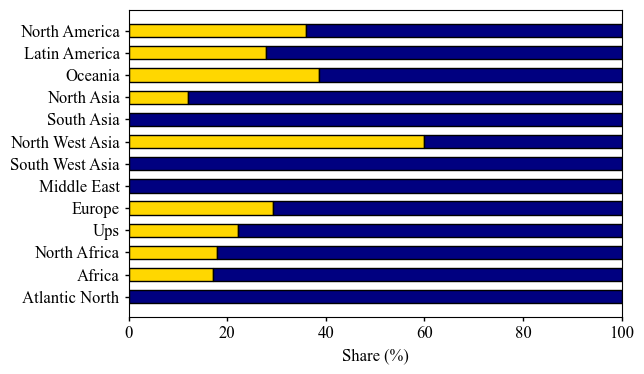

In [ ]:
# Calculate shares
regions = []
pv_cap_shares = []
wind_cap_shares = []
pv_gen_shares = []
wind_gen_shares = []

for key, value in regions_dic.items():
    regions.append(key)
    total_cap = value['wind_installed'] + value['pv_installed']
    total_gen = value['total_wind_yearly'] + value['total_pv_yearly']
    pv_cap_share = value['pv_installed'] / total_cap * 100
    wind_cap_share = 100 - pv_cap_share
    pv_gen_share = value['total_pv_yearly'] / total_gen * 100
    wind_gen_share = value['total_wind_yearly'] / total_gen * 100
    pv_cap_shares.append(pv_cap_share)
    wind_cap_shares.append(wind_cap_share)
    pv_gen_shares.append(pv_gen_share)
    wind_gen_shares.append(wind_gen_share)

num_regions = len(regions)

# Create figure and axes
fig, ax = plt.subplots(figsize=(6.6, num_regions * 0.3))

bar_width = 0.6
y_positions = np.arange(num_regions)
ax.barh(y_positions , pv_cap_shares, height=bar_width, color='gold', edgecolor='black', label='Solar PV')
ax.barh(y_positions, wind_cap_shares, height=bar_width, left=pv_cap_shares, color='navy', edgecolor='black', label='Wind')
formatted_regions = [region.replace('_', ' ').title() for region in regions]
ax.set_yticks(y_positions)
ax.set_yticklabels(formatted_regions, fontsize=12)
ax.set_xlim(0, 100)
ax.set_xlabel('Share (%)', fontsize=12)
ax.invert_yaxis()
ax.grid(True, axis='x')
ax.grid(False)
ax.tick_params(axis='both', which='both', bottom=True, top=False, direction='out', length=3, width=1, color='black')
plt.tight_layout()
plt.savefig(f'{output_path_figures}/bar-chart-wind-solar-share.pdf', format='pdf')

plt.show()


## Plotting of monthly regional data

In [ ]:
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
month_periods = pd.period_range(start='2050-01', periods=12, freq='M')

def plot_region_monthly_data(region_key, region_value, ax):
    inflows = [region_value[f'inflow_{month}'] for month in months]
    outflows = [region_value[f'outflow_{month}'] for month in months]
    loads = [region_value[f'total_load_monthly'].loc[period] for period in month_periods]
    generations = [(region_value[f'total_pv_monthly'].loc[period] + region_value[f'total_wind_monthly'].loc[period]) for period in month_periods]
    curtailments = [region_value[f'total_curtailment_monthly'].loc[period] for period in month_periods]

    bar_width = 0.15
    r1 = range(len(months))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    r5 = [x + bar_width for x in r4]
    ax.grid(False)
    ax.bar(r1, inflows, color='green', width=bar_width, edgecolor='grey', label='Inflow')
    ax.bar(r2, [-outflow for outflow in outflows], color='red', width=bar_width, edgecolor='grey', label='Outflow')
    ax.bar(r3, [-load for load in loads], color='blue', width=bar_width, edgecolor='grey', label='Demand')
    ax.bar(r4, generations, color='orange', width=bar_width, edgecolor='grey', label='Generation')
    ax.bar(r5, curtailments, color='purple', width=bar_width, edgecolor='grey', label='Curtailment')

    ax.set_xlabel('Month', fontweight='bold')
    ax.set_ylabel('Flow in GWh', fontweight='bold')
    ax.set_ylim(-2.1e6, 1.5e6)
    ax.set_title(f'Region: {region_key}', fontweight='bold')
    ax.set_xticks([r + 2*bar_width for r in range(len(months))])
    ax.set_xticklabels(months)
    ax.grid(True, axis='y')
    ax.legend()

num_plots = len(regions_dic)
rows = (num_plots + 2) // 3

fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
axs = axs.flatten()

for idx, (region_key, region_value) in enumerate(regions_dic.items()):
    plot_region_monthly_data(region_key, region_value, axs[idx])

for idx in range(len(regions_dic), len(axs)):
    fig.delaxes(axs[idx])

plt.tight_layout()
plt.show()


## Weekly plot

<built-in function len>


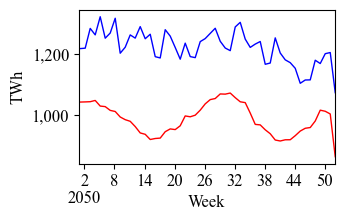

In [ ]:
# Group by week and sum the values
total_weekly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('W')).sum() * 1e-6
total_weekly_load = total_hourly_load.groupby(total_hourly_load.index.to_period('W')).sum() * 1e-6
total_weekly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('W')).sum() * 1e-6
# Remove the first entry
total_weekly_gen = total_weekly_gen.iloc[1:]
total_weekly_load = total_weekly_load.iloc[1:]
total_weekly_cur = total_weekly_cur.iloc[1:]
# Extract the week numbers and values
weeks = total_weekly_gen.index.to_timestamp()  # Convert period index to timestamp for plotting
values_gen = total_weekly_gen.values
values_load = total_weekly_load.values
values_cur = total_weekly_cur.values
print(len)
total_weekly_gen.to_csv('weekly_gen_trans.csv')
# Plotting
plt.figure(figsize=(3.3, 2))

# Plot load on top
plt.plot(weeks, values_gen, label='Generation', linestyle='-', color='blue', linewidth=1)
plt.plot(weeks, values_load, label='Demand', linestyle='-', color='red', linewidth=1)
plt.xlabel('Week', fontsize=12)
plt.ylabel('TWh', fontsize=12)
plt.xlim(pd.Timestamp('2050-01-01'), pd.Timestamp('2050-12-25'))
plt.gca().annotate('2050', xy=(0.02, -0.23), xycoords='axes fraction', ha='center', va='center')
#plt.legend(bbox_to_anchor=(0, 0.1), loc='lower left', frameon=False)  # Add a legend to the plot

# Create a range of weeks
all_weeks = pd.date_range(start=weeks[0], periods=52, freq='W')

# Customize x-axis ticks to show every 4th week
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%-U'))  # Remove leading zeros
plt.xticks(all_weeks[::6], fontsize=12)
ax = plt.gca()
def format_func(value, tick_number):
    return f'{value:,.0f}'

formatter = FuncFormatter(format_func)
plt.gca().yaxis.set_major_formatter(formatter)
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/weekly-gen-demand-line-plot.svg', format='svg')

# Show the plot
plt.show()

## Tornado plot of annual regional data

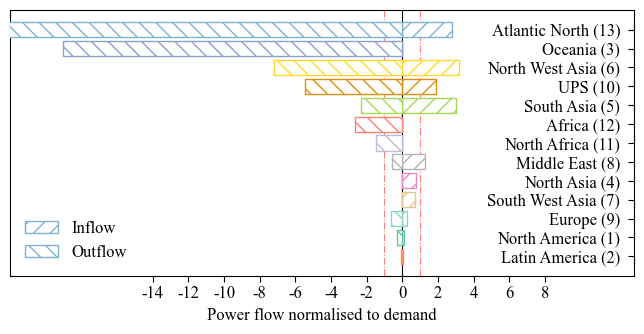

In [ ]:
# Data preparation
inflow_outflow_data = [
    (region_key, region_value['inflow']/region_value['total_load_yearly'], region_value['outflow']/region_value['total_load_yearly'])
    for region_key, region_value in regions_dic.items()
]
inflow_outflow_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

regions_inflow_outflow = [item[0] for item in inflow_outflow_data]
inflows = [item[1]  for item in inflow_outflow_data]  # TWh
outflows = [item[2] for item in inflow_outflow_data]  # TWh

# Plotting the data
fig, ax = plt.subplots(figsize=(6.6, 3.5))

for i, region in enumerate(regions_inflow_outflow):
    inflow_color = region_colors[region]
    region_name = f'{regions_dic[region]['region']} ({regions_dic[region]["bus"]})'
    ax.barh(region_name, inflows[i], color='white', hatch='//', edgecolor=inflow_color, label='Inflow' if i == 0 else "", zorder=10)
    ax.barh(region_name, -outflows[i], color='white', hatch='\\\\', edgecolor=inflow_color, label='Outflow' if i == 0 else "", zorder=10)
    # ax.annotate(f'{region.replace('_', ' ').title()}', xy=(-12.1e3, i), 
    #             xycoords='data', ha='left', va='center', fontsize=12, color='black')

ax.axvline(x=0, color='black', linewidth=0.8)
ax.axvline(x=1, color='red', linewidth=0.8, linestyle='-.', zorder=1, alpha=0.5)
ax.axvline(x=-1, color='red', linewidth=0.8, linestyle='-.', zorder=1, alpha=0.5)
ax.grid(False)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_xlabel('Power flow normalised to demand')
ax.set_xlim(-22, 13)
ax.legend(frameon=False, loc= 'lower left')
ax.invert_yaxis()
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
ax.yaxis.set_ticks_position('right')

# Set y-tick labels to the right of the left axis but align them to the left
for tick_label in ax.get_yticklabels():
    tick_label.set_ha('right')  # Align horizontally to the right
    tick_label.set_position((0.97, tick_label.get_position()[1]))  # Offset the position to the right of the axis

# for tick_label, region in zip(ax.get_yticklabels(), regions_inflow_outflow):
#     tick_label.set_color(region_colors[region.lower().replace(' ', '_')])
ax.set_xticks([-14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8])
ax.tick_params(axis='y', which='both', direction='in', length=4)
ax.tick_params(axis='x', which='both', direction='out', length=4)
fig.canvas.draw()
plt.tight_layout()
plt.savefig(f'{output_path_figures}/tornado-plot-inflows-outflows_black.svg', format='svg')

plt.show()


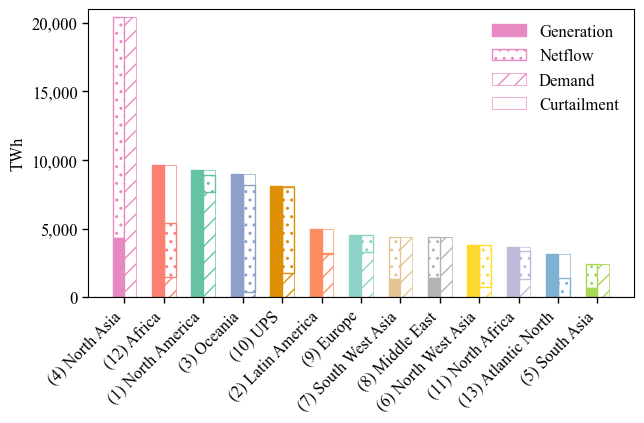

In [ ]:
# Data preparation (as given)
data = [
    (region_value['region'], region_value['total_wind_yearly'] + region_value['total_pv_yearly'], region_value['total_curtailment_yearly'], region_value['total_load_yearly'], region_value['inflow'], region_value['outflow'])
    for region_key, region_value in regions_dic.items()
]
data.sort(key=lambda x: max(x[1], x[2], x[3]), reverse=True)
regions = [item[0] for item in data] 
generations = [item[1] * 1e-3 for item in data] # TWh
curtailments = [item[2] * 1e-3 for item in data] # TWh
demands = [item[3] * 1e-3 for item in data] # TWh
netflows = [item[4] * 1e-3 - item[5] * 1e-3 for item in data] # TWh
# Plotting
fig, ax = plt.subplots(figsize=(6.6, 4.4))

# Bar chart for Generation and Curtailment by Region
bar_width = 0.3
x = range(len(regions))

hatch_patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']  # Define different hatching patterns

for i, region in enumerate(regions):
    color = region_colors[region.lower().replace(' ', '_')]  # Get the color for the region from region_colors
    
    ax.bar(x[i], generations[i], bar_width, label='Generation' if i == 0 else "", color=color, edgecolor=color, align='center')
    ax.bar(x[i] if netflows[i] > 0 else x[i] + bar_width, abs(netflows[i]), bar_width,bottom=generations[i] if netflows[i] > 0 else demands[i], label='Netflow' if i == 0 else "", color='none', hatch='..', edgecolor=color,align='center')
    ax.bar(x[i] + bar_width, demands[i], bar_width, label='Demand' if i == 0 else "", color='none', edgecolor=color,hatch='//',  align='center', linewidth=0.5)
    ax.bar(x[i] + bar_width, curtailments[i], bar_width, bottom=abs(netflows[i])+demands[i] if netflows[i] < 0 else demands[i], label='Curtailment' if i == 0 else "", color='none', edgecolor=color, align='center', linewidth=0.5)
    
region_labels = [f'({regions_dic[item.lower().replace(' ', '_')]['bus']}) {item}' for i, item in enumerate(regions)] # Set x-ticks and labels
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(region_labels, rotation=45, ha='right', fontsize=12)
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_ylabel('TWh', fontsize=12)
ax.grid(False)
ax.set_ylim(0, 21000)
ax = plt.gca()
formatter = ScalarFormatter(useMathText=False)
formatter.set_powerlimits((0, 0))  # Change the threshold for scientific notation
def format_func(value, tick_number):
    return f'{value:,.0f}'

formatter = FuncFormatter(format_func)
plt.gca().yaxis.set_major_formatter(formatter)
# Adjust the legend to show labels only once
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=False)
ax.yaxis.offsetText.set_fontsize(12)
ax.tick_params(axis='both', which='both', bottom=True, top=False, direction='out', length=4, width=1, color='black')
# Adjust layout
plt.tight_layout()
plt.savefig(f'{output_path_figures}/bar-chart-gen-netflow-demand-cur.svg', format='svg')
plt.show()


## **Radar charts**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# Data preparation (as given)
data = {
    region_key: [
        region_value['inflow'],  # Normalize to generation
        region_value['outflow'],  # Normalize to generation
        (region_value['total_load_yearly']),  # Normalize to generation
        (region_value['total_wind_yearly'] + region_value['total_pv_yearly']),  # Generation normalized to itself
        region_value['total_curtailment_yearly']  # Normalize to generation
    ]
    for region_key, region_value in regions_dic.items()
}

variables = ['Inflow', 'Outflow', 'Demand', 'Generation', 'Curtailment']
df = pd.DataFrame(data, index=variables)

def plot_radar_chart(region):
    num_vars = len(variables)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]
    values = df[region].tolist()
    values += values[:1]
    fig, ax = plt.subplots(figsize=(2.5, 2.5), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=1, linestyle='solid', color=region_colors[region])
    ax.fill(angles, values, color=region_colors[region], alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    formatted_title = format_title(region)
    #ax.set_title(formatted_title, size=12, color='black', y=1.1)
    ax.spines['polar'].set_visible(True)

    # if values[0] > 4/3*values[1]:
    #     ax.spines['polar'].set_edgecolor('red')  # net importer
    # elif values[0]*4/3 < values[1]:
    #     ax.spines['polar'].set_edgecolor('green') # net exporter
    # else:
    #     ax.spines['polar'].set_edgecolor('grey') # transmission nodes


    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/radar-chart-{region}.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()


def format_title(title):
    return ' '.join(word.capitalize() for word in title.split('_'))

def plot_all_radar_charts():
    for region in df.columns:
        plot_radar_chart(region)

plot_all_radar_charts()


## Chord diagram of netflows 

## Demand and supply graphs of each regions


In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')  

for key, value in regions_dic.items():
    print(key)
    # series_l = value["load"]
    # load = series_l.groupby(series_l.index.to_period('M')).sum()
    load = value['mean_load_monthly']
    wind = value["mean_wind_monthly"]
    pv = value["mean_pv_monthly"]

    # Extract values and months
    months = load.index.month
    load_values = load.values
    wind_values = wind.values
    pv_values = pv.values

    plt.figure(figsize=(12, 8))
    
    # # Stacked area plot for wind and PV
    plt.stackplot(months, wind_values, pv_values, labels=['Wind', 'PV'], colors=['blue', 'orange'], alpha=0.5)
    
    # Plot load on top
    plt.plot(months, load_values, label='Load', linestyle='--', color='red', linewidth=4)
    
    plt.title(f'{key}', fontsize=20, fontweight='bold')
    plt.xlabel('Month', fontsize=16)
    plt.ylabel('MW', fontsize=16)
    legend = plt.legend(loc='best', fontsize=16)
    for text in legend.get_texts():
        text.set_color('black')  # Set legend text color to black
        #text.set_fontweight('bold')  # Make legend text bold
    # Customize ticks
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=16)
    plt.yticks(fontsize=16)
    # Tight layout to ensure everything fits without overlapping
    plt.tight_layout()
    
    
    # Show the plot
    plt.show()

plt.figure(figsize=(12, 8))  # Increase figure size for better readability
# Plot line plots for Demand and Curtailment
# Plot stackplot for PV and wind generation
plt.stackplot(total_monthly_pv.index.month, total_monthly_pv.values, total_monthly_wind.values, labels=['PV Generation', 'Wind Generation'], colors=['green', 'blue'], alpha=0.5)
plt.plot(total_monthly_pv.index.month, total_monthly_load, label='Demand', color='cyan', linewidth=2, linestyle='-', marker='o')
plt.plot(total_monthly_pv.index.month, total_monthly_cur, label='Curtailment', color='red', linewidth=2, linestyle='--', marker='x')
plt.xlabel('Month', fontsize=16, fontweight='bold')  # Increase font size
plt.ylabel('Energy Metrics', fontsize=16, fontweight='bold')  # Increase font size and add a more descriptive label
plt.ylim(0, 7.1e9)
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)  # Move legend to upper left, increase font size, add frame and shadow
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for better readability

plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14, fontweight='bold')  # Increase x-tick font size and labels
plt.yticks(fontsize=14, fontweight='bold')  # Increase y-tick font size

plt.tight_layout()  # Adjust layout to fit elements better
plt.show()

## **Stochastic analysis**

[]

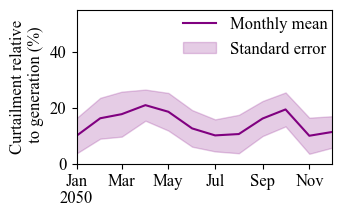

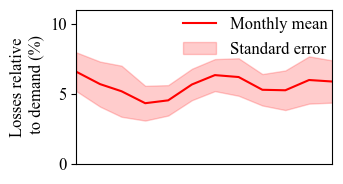

In [ ]:
month_index = monthly_cur_rel_to_gen.index.to_timestamp()
mean_rel_cur_month = hourly_cur_rel_to_gen.groupby(hourly_cur_rel_to_gen.index.to_period('M')).mean() * 100
std_rel_cur_month = hourly_cur_rel_to_gen.groupby(hourly_cur_rel_to_gen.index.to_period('M')).std() * 100
mean_rel_losses_month = hourly_losses_rel_to_load.groupby(hourly_losses_rel_to_load.index.to_period('M')).mean() * 100
std_rel_losses_month = hourly_losses_rel_to_load.groupby(hourly_losses_rel_to_load.index.to_period('M')).std() * 100


plt.figure(figsize=(3.3, 2))
plt.plot(month_index, mean_rel_cur_month.values, label='Monthly mean', color='purple', linestyle='-', linewidth=1.5)
plt.fill_between(month_index, mean_rel_cur_month - std_rel_cur_month, mean_rel_cur_month + std_rel_cur_month, color='purple', alpha=0.2, label='Standard error')
plt.grid(False)
plt.gca().annotate('2050', xy=(0, -0.23), xycoords='axes fraction', ha='center', va='center')
xticks = [pd.Timestamp('2050-01-01'), pd.Timestamp('2050-03-01'), pd.Timestamp('2050-05-01'), 
          pd.Timestamp('2050-07-01'), pd.Timestamp('2050-09-01'), pd.Timestamp('2050-11-01')]
xtick_labels = ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']
plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlim(pd.Timestamp('2050-01'), pd.Timestamp('2050-12'))
plt.ylabel('Curtailment relative\n to generation (%)')
plt.ylim(0,55)
plt.legend(frameon=False,bbox_to_anchor = [1.04, 1.05], loc='upper right')

plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/monthly-relative-curtailment.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.plot()
plt.figure(figsize=(3.3, 2))
plt.plot(month_index,mean_rel_losses_month.values, label='Monthly mean', color='red', linewidth=1.5)
plt.fill_between(month_index, mean_rel_losses_month - std_rel_losses_month, mean_rel_losses_month + std_rel_losses_month, color='red', alpha=0.2, label='Standard error')
#plt.gca().annotate('2050', xy=(0, -0.23), xycoords='axes fraction', ha='center', va='center')
xticks = [pd.Timestamp('2050-01-01'), pd.Timestamp('2050-03-01'), pd.Timestamp('2050-05-01'), 
          pd.Timestamp('2050-07-01'), pd.Timestamp('2050-09-01'), pd.Timestamp('2050-11-01')]
xtick_labels = ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']
#plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xticks([])
plt.xlim(pd.Timestamp('2050-01'), pd.Timestamp('2050-12'))
plt.grid(False)
plt.xlabel('')
plt.ylim(0,11)
plt.ylabel('Losses relative\n to demand (%)')
plt.legend(frameon=False, bbox_to_anchor = [1.04, 1.05], loc='upper right')
plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/monthly-relative-losses.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.plot()


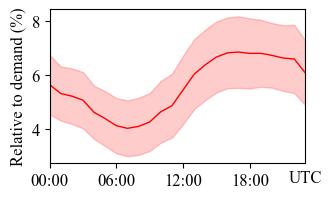

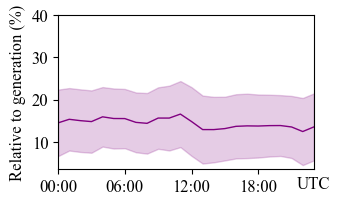

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming hourly_losses_rel_to_load and hourly_cur_rel_to_gen are defined

# Hourly losses
hourly_stats_losses = hourly_losses_rel_to_load.groupby(hourly_losses_rel_to_load.index.hour)
hourly_means_losses = hourly_stats_losses.mean() * 100
hourly_stds_losses = hourly_stats_losses.std() * 100

# Plotting
plt.figure(figsize=(3.3, 2))
plt.plot(hourly_means_losses.index, hourly_means_losses, label='Average Hourly Losses', color='red', linewidth=1)
plt.fill_between(hourly_means_losses.index, hourly_means_losses - hourly_stds_losses, hourly_means_losses + hourly_stds_losses, color='red', alpha=0.2, label='Standard error')
plt.ylabel('Relative to demand (%)')
plt.xticks([0, 6, 12, 18], ['00:00', '06:00', '12:00', '18:00'])
plt.xlim(0, 23)
plt.grid(False)
plt.gca().annotate('UTC', xy=(1, -0.1), xycoords='axes fraction', ha='center', va='center')
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/average-hourly-losses.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

# Hourly curtailment
hourly_stats_cur = hourly_cur_rel_to_gen.groupby(hourly_cur_rel_to_gen.index.hour)
hourly_means_cur = hourly_stats_cur.mean() * 100
hourly_stds_cur = hourly_stats_cur.std() * 100

# Plotting
plt.figure(figsize=(3.3, 2))
plt.plot(hourly_means_cur.index, hourly_means_cur, label='Curtailment', color='purple', linewidth=1)
plt.fill_between(hourly_means_cur.index, hourly_means_cur - hourly_stds_cur, hourly_means_cur + hourly_stds_cur, color='purple', alpha=0.2, label='Standard error')
plt.ylabel('Relative to generation (%)')
plt.xticks([0, 6, 12, 18], ['00:00', '06:00', '12:00', '18:00'])
plt.xlim(0, 23)
plt.yticks([10, 20, 30, 40])
plt.grid(False)
plt.gca().annotate('UTC', xy=(1, -0.1), xycoords='axes fraction', ha='center', va='center')
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/average-hourly-curtailment.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()


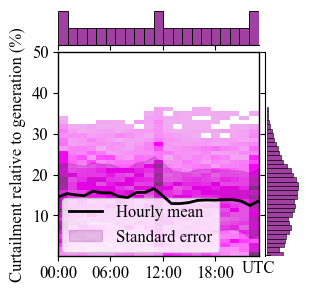

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming hourly_cur_rel_to_gen is defined as a Series
hourly_cur_rel_to_gen_ = hourly_cur_rel_to_gen * 100

# Convert the Series to a DataFrame and add an 'hour' column
df_hourly_cur_rel_to_gen = hourly_cur_rel_to_gen_.reset_index()
df_hourly_cur_rel_to_gen['hour'] = df_hourly_cur_rel_to_gen['snapshot'].dt.hour

# Rename the Series column to 'rel_cur'
df_hourly_cur_rel_to_gen.rename(columns={df_hourly_cur_rel_to_gen.columns[1]: 'rel_cur'}, inplace=True)

# Set font size to 12
plt.rcParams.update({'font.size': 12})

# Define the desired width and height of the plot
width = 3.3  # in inches
height = 3.3  # in inches

# Create a JointGrid with the specified size
g = sns.JointGrid(data=df_hourly_cur_rel_to_gen, x='hour', y='rel_cur', height=height)

# Plot the joint plot with histograms
g = g.plot(sns.histplot, sns.histplot, color='purple')

# Add KDE to the y-axis marginal histogram
sns.kdeplot(data=df_hourly_cur_rel_to_gen['rel_cur'], ax=g.ax_marg_y, color='black', linewidth=1.5)

# Remove the marginal histogram on the x-axis
#g.ax_marg_x.clear()

# Remove labels from the top axis
g.ax_marg_x.set_xticks([])
g.ax_marg_x.set_xticklabels([])

# Remove the top and right spines
g.ax_joint.spines['top'].set_visible(False)
g.ax_joint.spines['right'].set_visible(False)

# Remove the negative ticks and labels on the top axis
g.ax_joint.xaxis.set_ticks_position('bottom')
g.ax_joint.xaxis.set_tick_params(top=False, labeltop=False)

# Plot the overlay plot on the same axis
ax = g.ax_joint
ax.plot(hourly_means_cur.index, hourly_means_cur, label='Hourly mean', color='black', linewidth=2, zorder=10)
ax.fill_between(hourly_means_cur.index, hourly_means_cur - hourly_stds_cur, hourly_means_cur + hourly_stds_cur, color='purple', alpha=0.2, label='Standard error')
ax.set_ylabel('Curtailment relative to generation (%)')
ax.set_xlabel('')
ax.set_xticks([0, 6, 12, 18])
ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00'])
ax.set_xlim(0, 23)
ax.set_ylim(0, hourly_cur_rel_to_gen_.max())
ax.set_yticks([10, 20, 30, 40, 50])
ax.grid(False)
ax.legend(loc='lower left', bbox_to_anchor= [-0.02, -0.02])
ax.annotate('UTC', xy=(1, -0.06), xycoords='axes fraction', ha='center', va='center')
# Add a solid box around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/curtailment-stats.pdf', format='pdf')
plt.show()


snapshot
0     5.647114
1     5.322027
2     5.225139
3     5.072669
4     4.624258
5     4.394241
6     4.132261
7     4.035442
8     4.108373
9     4.270340
10    4.649802
11    4.871217
12    5.453307
13    6.036455
14    6.382933
15    6.669232
16    6.823363
17    6.852432
18    6.802668
19    6.805292
20    6.729685
21    6.631310
22    6.597006
23    6.077200
dtype: float64


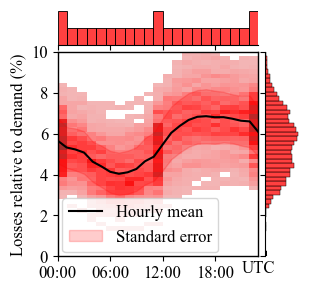

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming hourly_cur_rel_to_gen is defined as a Series
hourly_cur_rel_to_gen_ = hourly_losses_rel_to_load * 100

# Convert the Series to a DataFrame and add an 'hour' column
df_hourly_cur_rel_to_gen = hourly_cur_rel_to_gen_.reset_index()
df_hourly_cur_rel_to_gen['hour'] = df_hourly_cur_rel_to_gen['snapshot'].dt.hour

# Rename the Series column to 'rel_cur'
df_hourly_cur_rel_to_gen.rename(columns={df_hourly_cur_rel_to_gen.columns[1]: 'rel_cur'}, inplace=True)

# Set font size to 12
plt.rcParams.update({'font.size': 12})

# Define the desired width and height of the plot
width = 3.3  # in inches
height = 3.3  # in inches

# Create a JointGrid with the specified size
g = sns.JointGrid(data=df_hourly_cur_rel_to_gen, x='hour', y='rel_cur', height=height)

# Plot the joint plot with histograms
g = g.plot(sns.histplot, sns.histplot, color='red')

# Add KDE to the y-axis marginal histogram
sns.kdeplot(data=df_hourly_cur_rel_to_gen['rel_cur'], ax=g.ax_marg_y, color='black', linewidth=1.5)

# Remove the marginal histogram on the x-axis
#g.ax_marg_x.clear()

# Remove labels from the top axis
g.ax_marg_x.set_xticks([])
g.ax_marg_x.set_xticklabels([])

# Remove the top and right spines
g.ax_joint.spines['top'].set_visible(False)
g.ax_joint.spines['right'].set_visible(False)

# Remove the negative ticks and labels on the top axis
g.ax_joint.xaxis.set_ticks_position('bottom')
g.ax_joint.xaxis.set_tick_params(top=False, labeltop=False)

# Plot the overlay plot on the same axis
ax = g.ax_joint
print(hourly_means_losses)
ax.plot(hourly_means_losses.index, hourly_means_losses, label='Hourly mean', color='black', linewidth=1.5)
ax.fill_between(hourly_means_losses.index, hourly_means_losses - hourly_stds_losses, hourly_means_losses + hourly_stds_losses, color='red', alpha=0.2, label='Standard error')
ax.set_ylabel('Losses relative to demand (%)')
ax.set_xticks([0, 6, 12, 18], ['00:00', '06:00', '12:00', '18:00'])
ax.set_xlim(0, 23)
ax.set_ylim(0, 10)
ax.grid(False)
ax.set_xlabel('')
ax.legend(loc='lower left', bbox_to_anchor= [-0.02, -0.02])
ax.annotate('UTC', xy=(1, -0.06), xycoords='axes fraction', ha='center', va='center')
# Add a solid box around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/losses-stats.pdf', format='pdf')
plt.show()


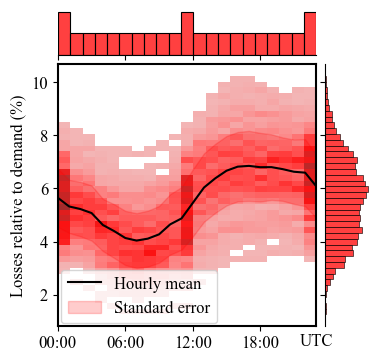

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming hourly_cur_rel_to_gen is defined as a Series
hourly_cur_rel_to_gen_ = hourly_losses_rel_to_load * 100

# Convert the Series to a DataFrame and add an 'hour' column
df_hourly_cur_rel_to_gen = hourly_cur_rel_to_gen_.reset_index()
df_hourly_cur_rel_to_gen['hour'] = df_hourly_cur_rel_to_gen['snapshot'].dt.hour

# Rename the Series column to 'rel_cur'
df_hourly_cur_rel_to_gen.rename(columns={df_hourly_cur_rel_to_gen.columns[1]: 'rel_cur'}, inplace=True)

# Set font size to 12
plt.rcParams.update({'font.size': 12})

# Define the desired width and height of the plot
width = 3.3  # in inches
height = 4  # in inches

# Create a JointGrid with the specified size
g = sns.JointGrid(data=df_hourly_cur_rel_to_gen, x='hour', y='rel_cur', height=height)

# Plot the joint plot with histograms
g = g.plot(sns.histplot, sns.histplot, color='red')

# Remove the marginal histogram on the x-axis
#g.ax_marg_x.clear()

# Remove labels from the top marginal axis
g.ax_marg_x.set_xticks([])
g.ax_marg_x.set_xticklabels([])

# Remove the top and right spines
g.ax_joint.spines['top'].set_visible(False)
g.ax_joint.spines['right'].set_visible(False)

# Remove ticks and labels from the top joint axis
g.ax_joint.xaxis.set_ticks([])
g.ax_joint.xaxis.set_ticklabels([])

# Plot the overlay plot on the same axis
ax = g.ax_joint
ax.plot(hourly_means_losses.index, hourly_means_losses, label='Hourly mean', color='black', linewidth=1.5)
ax.fill_between(hourly_means_losses.index, hourly_means_losses - hourly_stds_losses, hourly_means_losses + hourly_stds_losses, color='red', alpha=0.2, label='Standard error')
ax.set_ylabel('Losses relative to demand (%)')
ax.set_xticks([0, 6, 12, 18])
ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00'])
ax.set_xlim(0, 23)
#ax.set_ylim(0, 11)
ax.grid(False)
ax.set_xlabel('')
ax.legend(loc='lower left', bbox_to_anchor=[-0.02, -0.02])
ax.annotate('UTC', xy=(1, -0.06), xycoords='axes fraction', ha='center', va='center')

# Add a solid box around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_edgecolor('black')

# Save and show the plot
plt.show()


## Statistics of losses

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Step 1: Sort the data
sorted_losses = np.sort(total_hourly_abs_losses)

# Step 2: Calculate cumulative losses
cumulative_losses = np.cumsum(sorted_losses)

# Step 3: Calculate cumulative proportion
total_loss = cumulative_losses[-1]
cumulative_proportion_losses = cumulative_losses / total_loss
cumulative_proportion_events = np.arange(1, len(sorted_losses) + 1) / len(sorted_losses)

# Step 4: Plot the Lorenz curve
plt.figure(figsize=(8, 6))
plt.plot(cumulative_proportion_events, cumulative_proportion_losses, label="Lorenz Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label="Equality Line")
plt.xlabel("Cumulative proportion of events")
plt.ylabel("Cumulative proportion of losses")
plt.legend()
plt.title("Lorenz Curve")
plt.show()

# Step 5: Calculate the Gini coefficient
lorenz_curve_area = np.trapz(cumulative_proportion_losses, cumulative_proportion_events)
gini_coefficient = 1 - 2 * lorenz_curve_area

print(f"Gini Coefficient: {gini_coefficient}")

# To find specific statistics, such as the percentage of events responsible for 50% of the losses
target_percentage = 0.50
events_responsible = cumulative_proportion_events[np.searchsorted(cumulative_proportion_losses, target_percentage)]
print(f"{events_responsible*100:.2f}% of the events are responsible for {target_percentage*100}% of the losses.")


## Correlation matrix

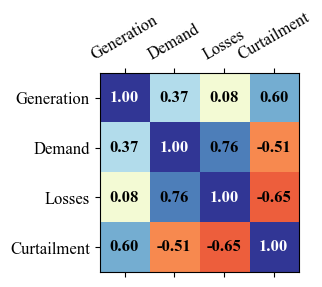

In [ ]:
# Combine into a DataFrame
data = pd.DataFrame({
    'Generation': total_hourly_gen,
    'Demand': total_hourly_load,
    'Losses': total_hourly_abs_losses,
    'Curtailment': total_hourly_cur
    
})

# Calculate pairwise correlations
correlation_matrix = data.corr()

# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(3.3, 3.3))

# Display the matrix values with reversed colormap
cax = ax.matshow(correlation_matrix, cmap='RdYlBu', vmin=-1, vmax=1)

# Set axis ticks and labels
ax.grid(False)
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.index)))
ax.set_xticklabels(correlation_matrix.columns, rotation=30, fontsize=12)
ax.set_yticklabels(correlation_matrix.index, fontsize=12)

# Add text annotations
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.index)):
        plt.text(i, j, f'{correlation_matrix.iloc[j, i]:.2f}', ha='center', va='center', color= 'white' if i==j else 'black', fontsize=12, fontweight='bold')

# Title and layout adjustments
plt.tight_layout()
plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/correlation-matrix.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()


## Fourier Transform

### Global fourier transform

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
# Convert to numpy array
hourly_p_trans_rel_gen_array = total_actual_flow.values

# Step 2: Perform Fourier Transform
# Number of sample points
N = len(hourly_p_trans_rel_gen_array)
# Sample spacing (assuming hourly data, so 1 hour)
T = 1.0

# Perform FFT
yf = fft(hourly_p_trans_rel_gen_array)
xf = fftfreq(N, T)[:N//2]
# Calculate the frequencies for 3-hour, 6-hour, 12-hour, daily, and weekly intervals
three_hour_freq = 1 / 3.0
six_hour_freq = 1 / 6.0
eight_hour_freq = 1 / 8.0
half_daily_freq = 1 / 12.0
daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)

frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq,half_daily_freq, daily_freq, weekly_freq]
labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
# Step 3: Plot the FFT results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# Set custom x-ticks and labels
ax.set_xticks(frequencies)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlim(-0.01, 1/5.5)

ax.set_xlabel('Frequency', fontweight='bold')
ax.set_ylabel('MW', fontweight='bold')
ax.set_title(f'Fourier Transform of Transmitted Electricity', fontweight='bold')
ax.grid(True, axis='x')

plt.show()

### Regional fourier transform

In [ ]:
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})
def format_region_name(region_name):
    return ' '.join(word.capitalize() for word in region_name.split('_'))

def plot_fourier_transform(region_key, region_value):
    series = region_value["netflow_series"]
    series = series.to_numpy()
    N = len(series)
    T = 1.0
    yf = fft(series)
    xf = fftfreq(N, T)[:N // 2]
    
    three_hour_freq = 1 / 3.0
    six_hour_freq = 1 / 6.0
    eight_hour_freq = 1 / 8.0
    half_daily_freq = 1 / 12.0
    daily_freq = 1 / 24.0
    weekly_freq = 1 / (24.0 * 7)
    
    frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq, half_daily_freq, daily_freq, weekly_freq]
    labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
    
    fig, ax = plt.subplots(figsize=(2.6, 1.8))
    ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]), color=region_colors[region_key], linewidth=0.75)
    ax.set_xticks(frequencies)
    #ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xticklabels([])
    ax.set_xlim(-0.01, 1/5)
    #ax.set_xlabel('Frequency')
    #ax.set_ylabel('Net flow (GW)')
    formatted_title = f'({regions_dic[region_key]['bus']}) {format_region_name(region_key)}'
    ax.set_title(f'{formatted_title}', fontsize=12)
    ax.set_yscale('log')
    ax.set_ylim(1e-2, 3e3)
    ax.grid(False)
    #ax.grid(True, axis='x')
    #ax.xaxis.set_label_coords(0.95, -0.05)
    plt.tight_layout()
    plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/fourier-netflow-{region_key}.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()

# Loop through each region and plot individually
for region_key, region_value in regions_dic.items():
    plot_fourier_transform(region_key, region_value)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq

plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

def format_region_name(region_name):
    return ' '.join(word.capitalize() for word in region_name.split('_'))

def plot_fourier_transform(region_key, region_value):
    series = region_value["netflow_series"]
    series = series.to_numpy()
    N = len(series)
    T = 1.0
    yf = fft(series)
    xf = fftfreq(N, T)[:N // 2]
    
    three_hour_freq = 1 / 3.0
    six_hour_freq = 1 / 6.0
    eight_hour_freq = 1 / 8.0
    half_daily_freq = 1 / 12.0
    daily_freq = 1 / 24.0
    weekly_freq = 1 / (24.0 * 7)
    
    frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq, half_daily_freq, daily_freq, weekly_freq]
    labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
    
    fig_width = 1.4  # Desired x-axis length in inches
    fig_height = 1.6  # Adjust this to control overall figure height
    margins = (0.3, 0)  # Left and right margins in inches

    total_width = fig_width + margins[0] + margins[1]
    fig, ax = plt.subplots(figsize=(total_width, fig_height))

    ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]), color=region_colors[region_key], linewidth=0.75)
    ax.set_xticks(frequencies)
    ax.set_xticklabels([])
    ax.set_xlim(-0.01, 1/5)
    formatted_title = f'({regions_dic[region_key]["bus"]}) {format_region_name(region_key)}'
    ax.set_title(f'{formatted_title}', fontsize=12)
    ax.grid(False)
    
    # Adjust subplot parameters to fit the axis length
    fig.subplots_adjust(left=margins[0]/total_width, right=1-margins[1]/total_width, top=0.85, bottom=0.2)
    
    plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/fourier-netflow-{region_key}.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()

# Loop through each region and plot individually
for region_key, region_value in regions_dic.items():
    plot_fourier_transform(region_key, region_value)


# **Maps**

## Global grid map

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Geod
import geopandas as gpd
from cartopy.geodesic import Geodesic
import matplotlib.colors as mcolors

plt.rc("figure", figsize=(6.6, 4))
# Function to convert RGB tuple to hex
def rgb_to_hex(rgb):
    return mcolors.to_hex(rgb)

def darken_color(color, factor=0.8):
    """
    Darkens a color by a given factor.
    color: The color to be darkened (in RGB or hex format).
    factor: The factor to darken the color (default is 0.8).
    """
    rgb = mcolors.to_rgb(color)  # Convert to RGB if in hex
    darker_rgb = [factor * c for c in rgb]  # Apply factor to each component
    return mcolors.to_hex(darker_rgb)  # Convert back to hex

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key


# Ensure that we have unique regions in the order defined in regions_dic
ordered_regions = [key for key in regions_dic if key in world['bus'].unique()]

# Convert colors to hex
colors = [rgb_to_hex(region_colors[bus]) if bus in region_colors else '#cccccc' for bus in world['bus']]

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)})
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed


# Plot country regions with assigned colors
world.plot(ax=ax, color=colors, edgecolor='white', legend=False,transform=ccrs.PlateCarree(), linewidth=0.5)
# Create a custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=region_colors[region], markersize=10, label=f'({i+1}) {region.replace('_', ' ').title()}')
    for i, region in enumerate(ordered_regions)
]
# ax.legend(
#     handles=handles, 
#     loc='upper right', 
#     bbox_to_anchor=(0, 0), 
#     bbox_transform=ax.transAxes, 
#     fancybox=False, 
#     shadow=False, 
#     ncol=1, 
#     fontsize=12, 
#     frameon=False, 
#     framealpha=1, 
#     edgecolor='black'
# )

for i, bus in enumerate(n.buses.index, start=1):
    color_ = color_ = darken_color(region_colors[bus], factor=0.6)
    x, y = n.buses.loc[bus, ['x', 'y']]
    if i == 6:
        x, y = x, y
    ax.scatter(x, y, s=250, color=color_, edgecolor='black', zorder=5, linewidths=0.5, transform=ccrs.PlateCarree())
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold', transform=ccrs.PlateCarree())

# Plot links
for i, link in enumerate(n.links.index[0::2]):
    if link != 'north_america_to_ups_0':
        bus0 = n.links.loc[link, 'bus0']
        bus1 = n.links.loc[link, 'bus1']
        x0, y0 = n.buses.loc[bus0, ['x', 'y']]
        x1, y1 = n.buses.loc[bus1, ['x', 'y']]
        ax.plot([x0, x1], [y0, y1], color='black', linewidth=1, zorder=4, transform=ccrs.PlateCarree())
    else:
        bus0 = n.links.loc['north_america_to_ups_0', 'bus0']
        bus1 = n.links.loc['north_america_to_ups_0', 'bus1']
        x0, y0 = n.buses.loc[bus0, ['x', 'y']]    
        x1, y1 = -143, n.buses.loc[bus1, ['x', 'y']]['y']
        ax.plot([x0, x1], [y0, y1], color='black', linewidth=1, zorder=4, transform=ccrs.PlateCarree())
        x0, y0 = x1+0.9, y1    
        x1, y1 = -160, y1
        ax.annotate('', xy=(x1, y1), xytext=(x0, y0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=1), transform=ccrs.PlateCarree()) 
        ax.text(-167, y1, '10', color='black', fontsize=12, ha='left', va='top', zorder=6, fontweight='bold', transform=ccrs.PlateCarree()) 
        x0, y0 = 179, y1    
        x1, y1 = n.buses.loc[bus1, ['x', 'y']]
        ax.annotate('', xy=(x0, y0), xytext=(x1, y1),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=1), transform=ccrs.PlateCarree()) 
        ax.text(x0+2, y0, '1', color='black', fontsize=12, ha='right', va='top', zorder=6, fontweight='bold', transform=ccrs.PlateCarree())     
ax.spines['geo'].set_visible(False)
plt.show()


## Heat maps

0.5266077758514209
0.49661029714856786
1.3505797331305982
1.255345542877812
1.410511100615686
2.1016589309375573
1.3734250428036738
3.0851474503171663
1.550748775667084
0.03843398187580063
1.025955726664757
0.3383704712132324
5.063699176393695


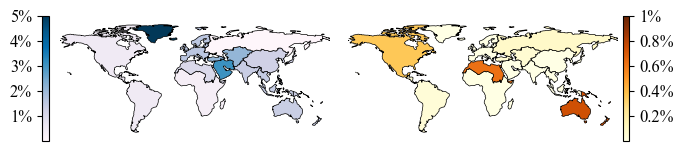

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_cap_wind_area[key] = value["wind_installed"] / wind_density / area * 1e9 * 100  # to go from GW to to W
    print(installed_cap_wind_area[key])
    installed_cap_pv_area[key] = value["pv_installed"] / pv_density / area * 1e9 * 100
    installed_cap_land_share[key] = installed_cap_wind_area[key] + installed_cap_pv_area[key]

values_dics = [installed_cap_wind_area, installed_cap_pv_area, installed_cap_land_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap, setting vmin and vmax
    if i == 0:
        norm = Normalize(vmin=0, vmax=5)
        cmap = cm.PuBu
    else:
        norm = Normalize(vmin=0, vmax=1)
        cmap = cm.YlOrBr

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    ax.spines['geo'].set_visible(False)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    
    if i == 0:
        cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')
        cbar.set_ticks([1, 2, 3, 4, 5])  # Customize the ticks
        cbar.set_ticklabels(['1%', '2%', '3%', '4%', '5%'])  # Customize the tick labels
    else:
        cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Customize the ticks
        cbar.set_ticklabels(['0.2%', '0.4%', '0.6%', '0.8%', '1%'])  # Customize the tick labels

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])  # Adjust layout to prevent overlap
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/heat-map-wind-pv-land-use-share.pdf', format='pdf', bbox_inches='tight')
plt.show()


0.5266077758514209
0.49661029714856786
1.3505797331305982
1.255345542877812
1.410511100615686
2.1016589309375573
1.3734250428036738
3.0851474503171663
1.550748775667084
0.03843398187580063
1.025955726664757
0.3383704712132324
5.063699176393695


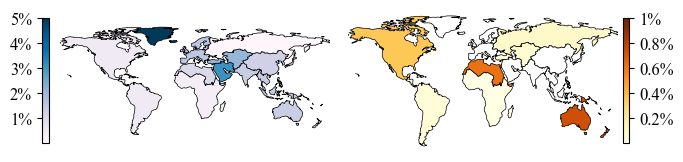

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_cap_wind_area[key] = value["wind_installed"] / wind_density / area * 1e9 * 100  # to go from GW to to W
    print(installed_cap_wind_area[key])
    installed_cap_pv_area[key] = value["pv_installed"] / pv_density / area * 1e9 * 100
    installed_cap_land_share[key] = installed_cap_wind_area[key] + installed_cap_pv_area[key]

values_dics = [installed_cap_wind_area, installed_cap_pv_area, installed_cap_land_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap, setting vmin and vmax
    if i == 0:
        norm = Normalize(vmin=0, vmax=5)
        cmap = cm.PuBu
    else:
        norm = Normalize(vmin=0, vmax=1)
        cmap = cm.YlOrBr

    # Mask zero values to be white for solar generation
    if i == 1:
        regions['value'] = regions['value'].apply(lambda x: np.nan if x == 0 else x)
    
    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', missing_kwds={'color': 'white'}, transform=ccrs.PlateCarree(), linewidth=0.5)

    ax.spines['geo'].set_visible(False)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    
    if i == 0:
        cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')
        cbar.set_ticks([1, 2, 3, 4, 5])  # Customize the ticks
        cbar.set_ticklabels(['1%', '2%', '3%', '4%', '5%'])  # Customize the tick labels
    else:
        cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Customize the ticks
        cbar.set_ticklabels(['0.2%', '0.4%', '0.6%', '0.8%', '1%'])  # Customize the tick labels

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])  # Adjust layout to prevent overlap
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/heat-map-wind-pv-land-use-share.pdf', format='pdf', bbox_inches='tight')
plt.show()


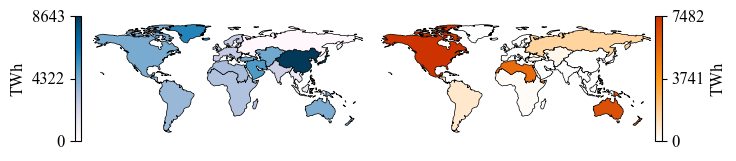

In [ ]:
import warnings
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.cm as cm

# Example dictionaries (Replace with actual data)
installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
for key, value in regions_dic.items():
    installed_capacity_wind_dic[key] = value["total_wind_yearly"] * 1e-3
    installed_capacity_pv_dic[key] = value["total_pv_yearly"] * 1e-3

values_dics = [installed_capacity_wind_dic, installed_capacity_pv_dic]

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world['name'] != "Antarctica"]
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

# Create a custom colormap for solar generation with a steep gradient
colors = [(1, 1, 1), (1, 0.6, 0.1), (0.8, 0.2, 0)]
n_bins = 100
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    if values_dic:  # Check if the dictionary is not empty
        world['value'] = world['bus'].map(values_dic)
        regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})
        ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())

        # Set normalization with a steep gradient
        vmin = min(values_dic.values())
        vmax = max(values_dic.values())
        norm = Normalize(vmin=vmin, vmax=vmax)
        cmap = cm.PuBu if i == 0 else custom_cmap

        regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

        ax.spines['geo'].set_visible(False)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []

        if i == 0:
            cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])
            cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
            cbar.ax.yaxis.set_ticks_position('left')
            cbar.ax.yaxis.set_label_position('left')
            cbar.set_label('TWh')
            cbar.set_ticks([0, vmax / 2, vmax])
            cbar.set_ticklabels(['0', f'{vmax / 2:.0f}', f'{vmax:.0f}'])
        else:
            cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])
            cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
            cbar.set_label('TWh')
            cbar.set_ticks([0, vmax / 2, vmax])
            cbar.set_ticklabels(['0', f'{vmax / 2:.0f}', f'{vmax:.0f}'])

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/heat-map-wind-pv-gen.pdf', format='pdf', bbox_inches='tight')
plt.show()


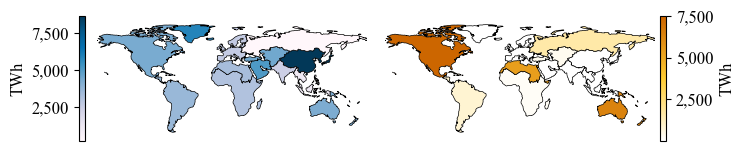

In [ ]:
import warnings
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.cm as cm

# Dictionary setup (example)
installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
for key, value in regions_dic.items():
    installed_capacity_wind_dic[key] = value["total_wind_yearly"] * 1e-3
    installed_capacity_pv_dic[key] = value["total_pv_yearly"] * 1e-3

values_dics = [installed_capacity_wind_dic, installed_capacity_pv_dic]

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world['name'] != "Antarctica"]
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

# Create a custom colormap for the solar generation
colors = [(1, 1, 1), (1, 0.8, 0.2), (0.8, 0.4, 0)]
n_bins = 100
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    if values_dic:  # Check if the dictionary is not empty
        world['value'] = world['bus'].map(values_dic)
        regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})
        ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())

        norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
        cmap = cm.PuBu if i == 0 else custom_cmap

        regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

        if i == 1:
            zero_gen = regions[regions['value'] == 0]
            #zero_gen.plot(ax=ax, facecolor="none", edgecolor="black", hatch='xx', transform=ccrs.PlateCarree(), linewidth=0.5)

        ax.spines['geo'].set_visible(False)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []

        if i == 0:
            cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])
            cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
            cbar.ax.yaxis.set_ticks_position('left')
            cbar.ax.yaxis.set_label_position('left')
            cbar.set_label('TWh')
            cbar.set_ticks([2500, 5000, 7500])
            cbar.set_ticklabels(['2,500', '5,000', '7,500'])
        else:
            cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])
            cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
            cbar.set_label('TWh')
            cbar.set_ticks([2500, 5000, 7500])
            cbar.set_ticklabels(['2,500', '5,000', '7,500'])

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/heat-map-wind-pv-gen.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_cap_wind_area[key] = value["wind_installed"] / wind_density / area * 1e9 * 100  # to go from GW to to W
    installed_cap_pv_area[key] = value["pv_installed"] / pv_density / area * 1e9 * 100
    installed_cap_land_share[key] = installed_cap_wind_area[key] + installed_cap_pv_area[key]

values_dics = [installed_cap_wind_area, installed_cap_pv_area, installed_cap_land_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.PuBu if i == 0 else cm.YlOrBr

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    ax.spines['geo'].set_visible(False)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    
    if i == 0:
        cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')
        cbar.set_ticks([1,  3, 5])  # Customize the ticks
        cbar.set_ticklabels(['1%', '3%', '5%'])  # Customize the tick labels
    else:
        cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_ticks([0.2, 0.4, 0.6])  # Customize the ticks
        cbar.set_ticklabels(['0.2%', '0.4%', '0.6%'])  # Customize the tick labels

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])  # Adjust layout to prevent overlap
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/wind-pv-land-use.svg', format='svg')
plt.show()

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_capacity_wind_dic[key] = value["wind_installed"] / 1e6
    installed_capacity_pv_dic[key] = value["pv_installed"] / 1e6
    installed_cap_pv_area[key] = value["wind_installed"] / area * 1e6
    installed_cap_wind_area[key] = value["pv_installed"] / area * 1e6
    curtailment_rel_to_gen[key] = value["total_curtailment_yearly"] / (value["total_wind_yearly"] + value["total_pv_yearly"])
    loads_dic[key] = (value["total_wind_yearly"] + value["total_pv_yearly"]) / value["total_load_yearly"]
    generation_dic[key] = value["total_wind_yearly"] + value["total_pv_yearly"] / 1e6
values_dics = [installed_capacity_pv_dic, installed_cap_pv_area,  installed_capacity_wind_dic,  installed_cap_wind_area, curtailment_rel_to_gen, generation_dic, loads_dic]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

for i, values_dic in enumerate(values_dics):
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    # Plotting the network with results
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

    # Add base map features
    ax.add_feature(cfeature.COASTLINE)

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.YlOrRd

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree())

    # for i, bus in enumerate(n.buses.index, start=1):
    #     x, y = n.buses.loc[bus, ['x', 'y']]
    #     ax.scatter(x, y, s=400, color='black', edgecolor='k', zorder=5)
    #     ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

    # Add a title to the figure
    if i == 0:
        plt.title('Installed Wind Capacity', fontsize=16)
    elif i == 1:
        plt.title('Density of Installed Wind Capacity', fontsize=16)
    elif i == 2:
        plt.title('Installed Solar Capacity', fontsize=16)
    elif i == 3:
        plt.title('Density of Installed Solar Capacity', fontsize=16)
    elif i == 4:
        plt.title('Annual Curtailment over Generation', fontsize=16)
    elif i == 5:
        plt.title('Annual Electricity Generation', fontsize=16)
    elif i == 6:
        plt.title('Annual Electricity Generation over Demand', fontsize=16)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
    if i == np.any([1, 3]):
        cbar.set_label('W/m2')
    elif i == np.any([5, 6]):
        cbar.set_label('TWh')
    elif i == 4:
        cbar.set_label('[-]')
    else:
        cbar.set_label('Terrawatts')


    plt.show()

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_cap_wind_area[key] = value["wind_installed"] / wind_density / area * 1e9 * 100 # to go from GW to to W
    installed_cap_pv_area[key] = value["pv_installed"] / pv_density / area * 1e9 * 100
    installed_cap_land_share[key] = installed_cap_wind_area[key] + installed_cap_pv_area[key]

values_dics = [installed_cap_wind_area,  installed_cap_pv_area, installed_cap_land_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

for i, values_dic in enumerate(values_dics):
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)})
    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.YlOrRd

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    # for i, bus in enumerate(n.buses.index, start=1):
    #     x, y = n.buses.loc[bus, ['x', 'y']]
    #     ax.scatter(x, y, s=400, color='black', edgecolor='k', zorder=5)
    #     ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

    # Add a title to the figure
    if i == 0:
        plt.title('Land Use of Installed Wind Capacity', fontsize=16)
    elif i == 1:
        plt.title('Land Use of Installed PV Capacity', fontsize=16)
    elif i == 2:
        plt.title('Land Use of Total Installed Capacity', fontsize=16)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
    cbar.set_label('%')

    ax.spines['geo'].set_visible(False)
    plt.show()

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

total_generation_global_share = {}
demand_global_share = {}
global_load = 0
global_generation = 0
for key, value in regions_dic.items():
    global_load += value["total_load_yearly"] 
    global_generation += (value["total_wind_yearly"] + value["total_pv_yearly"])
for key, value in regions_dic.items():
    area = region_area(key)
    total_generation_global_share[key] = (value["total_wind_yearly"] + value["total_pv_yearly"]) / global_generation * 100
    demand_global_share[key] = value["total_load_yearly"] / global_load * 100

values_dics = [total_generation_global_share,  demand_global_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

for i, values_dic in enumerate(values_dics):
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)})
    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    if i == 0:
        cmap = cm.PuBu
    elif i == 1:
        cmap = cm.OrRd

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    # for i, bus in enumerate(n.buses.index, start=1):
    #     x, y = n.buses.loc[bus, ['x', 'y']]
    #     ax.scatter(x, y, s=400, color='black', edgecolor='k', zorder=5)
    #     ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

    # Add a title to the figure
    if i == 0:
        plt.title('Share of Global Generation', fontsize=16)
    elif i == 1:
        plt.title('Share of Global Demand', fontsize=16)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
    cbar.set_label('%')

    ax.spines['geo'].set_visible(False)
    plt.show()

## Power flow chart

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

total_flow = 0
for key, value in netflows_links_series.items():
    total_flow += netflows_links[key]
share_values = [netflows_links[key] / total_flow for (key, value) in netflows_links.items()]
plt.rc("figure", figsize=(30, 30))

# Define coordinates for each region
coordinates = {
    "north_africa": (0, 0),
    "europe": (0, 1.5),
    "africa": (0.75, -1.5),
    "middle_east": (1.5, 0.75),
    "north_west_asia": (3, 1.5),
    "south_west_asia": (3, 0),
    "south_asia": (4.5, 0),
    "north_asia": (4.5, 1.5),
    "oceania": (4.5, -1.5),
    "ups": (1.5, 2.25),
    "atlantic_north": (-1.5, 1.5),
    "north_america": (-3, 1.5),  
    "latin_america": (-3, 0)
}

# Scale coordinates to fit the plot
scale = 5
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}
arrow_colors = {value['name']: netflows_links[key] for i, (key, value) in enumerate(links_dic.items())}  


# Plotting the network without background map
fig, ax = plt.subplots()
ax.set_xlim(-3.5*scale, 5.5*scale)
ax.set_ylim(-3.5*scale, 5.5*scale)

# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue
    ax.scatter(x, y, s=25000, color=region_colors[region_key_matched], zorder=5)
    region_name = region_key.replace('_', ' ').title()
    region_number = regions_dic[region_key]['bus']
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_number, color='white', fontsize=45, ha='center', va='center', zorder=6, fontweight='bold')

# Plot lines
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    if bus0 is None or bus1 is None:
        print('Region key is none')
        continue
    
    flow = arrow_colors[value['name']]
    linewidth = max(np.abs(flow) / 0.65e8, 0.5)
    color = region_colors.get(bus0 if flow_statements[key] else bus1, 'grey')

    if key == "1_10":
        # Draw the L-shaped line for link 1_10
        ax.plot([-3*scale, -3*scale], [1.5*scale, 2.25*scale], color=color, linewidth=linewidth)
        ax.plot([-3*scale, 1.5*scale], [2.25*scale, 2.25*scale], color=color, linewidth=linewidth)
    elif key == "4_10":
        # Draw the L-shaped line for link 4_10
        ax.plot([1.5*scale, 4.5*scale], [2.25*scale, 2.25*scale], color=color, linewidth=linewidth)
        ax.plot([4.5*scale, 4.5*scale], [2.25*scale, 1.5*scale], color=color, linewidth=linewidth)
    else:
        ax.plot([scaled_coordinates[bus0][0], scaled_coordinates[bus1][0]], 
                [scaled_coordinates[bus0][1], scaled_coordinates[bus1][1]], color=color, linewidth=linewidth)

# Remove axes for a cleaner look
ax.set_axis_off()

plt.show()

for i, (key, value) in enumerate(links_dic.items()):
    print(value['name'], share_values[i])


In [ ]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define coordinates for each region
coordinates = {
    "north_africa": (0, 0),
    "europe": (0, 1.5),
    "africa": (0.75, -1.5),
    "middle_east": (1.5, 0.75),
    "north_west_asia": (3, 1.5),
    "south_west_asia": (3, 0),
    "south_asia": (4.5, 0),
    "north_asia": (4.5, 1.5),
    "oceania": (4.5, -1.5),
    "ups": (1.5, 2.25),
    "atlantic_north": (-1.5, 1.5),
    "north_america": (-3, 1.5),  
    "latin_america": (-3, 0)
}

# Calculate total flow and share values
total_flow = sum(netflows_links.values())
share_values = [netflows_links[key] / total_flow for key in netflows_links]

# Scale coordinates to fit the plot
scale = 1.5  # Adjust the scale to fit within 6.6x6.6 inch plot
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}
arrow_colors = {value['name']: netflows_links[key] for key, value in links_dic.items()}

# Plotting the network without background map
fig, ax = plt.subplots(figsize=(6.6, 6.6))
plt.rc("font", size=12)

ax.set_xlim(-3.5 * scale, 5.5 * scale)
ax.set_ylim(-3.5 * scale, 5.5 * scale)

# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue
    ax.scatter(x, y, s=1000, color=region_colors[region_key_matched], zorder=5)  # Increased node size
    region_name = region_key.replace('_', ' ').title()
    region_number = regions_dic[region_key]['bus']
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_number, color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold')

# Plot lines
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    if bus0 is None or bus1 is None:
        print('Region key is none')
        continue
    
    flow = arrow_colors[value['name']]
    linewidth = max(np.abs(flow) / 0.327e9, 0.5)
    color = region_colors.get(bus0 if flow_statements[key] else bus1, 'grey')

    if key == "1_10":
        ax.plot([-3 * scale, -3 * scale], [1.5 * scale, 2.25 * scale], color=color, linewidth=linewidth)
        ax.plot([-3 * scale, 1.5 * scale], [2.25 * scale, 2.25 * scale], color=color, linewidth=linewidth)
    elif key == "4_10":
        ax.plot([1.5 * scale, 4.5 * scale], [2.25 * scale, 2.25 * scale], color=color, linewidth=linewidth)
        ax.plot([4.5 * scale, 4.5 * scale], [2.25 * scale, 1.5 * scale], color=color, linewidth=linewidth)
    else:
        ax.plot([scaled_coordinates[bus0][0], scaled_coordinates[bus1][0]], 
                [scaled_coordinates[bus0][1], scaled_coordinates[bus1][1]], color=color, linewidth=linewidth)

# Remove axes for a cleaner look
ax.set_axis_off()
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/flow-chart.pdf', format='pdf')
plt.show()


In [ ]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define coordinates for each region
coordinates = {
    "north_africa": (0, 0),
    "europe": (0, 1.5),
    "africa": (0.75, -1.5),
    "middle_east": (1.5, 0.75),
    "north_west_asia": (3, 1.5),
    "south_west_asia": (3, 0),
    "south_asia": (4.5, 0),
    "north_asia": (4.5, 1.5),
    "oceania": (4.5, -1.5),
    "ups": (1.5, 2.25),
    "atlantic_north": (-1.5, 1.5),
    "north_america": (-3, 1.5),  
    "latin_america": (-3, 0)
}

# Calculate total flow and share values
total_flow = sum(netflows_links.values())
share_values = [netflows_links[key] / total_flow for key in netflows_links]

# Scale coordinates to fit the plot
scale = 1.5  # Adjust the scale to fit within 6.6x6.6 inch plot
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}
arrow_colors = {value['name']: netflows_links[key] for key, value in links_dic.items()}

# Plotting the network without background map
fig, ax = plt.subplots(figsize=(6.6, 6.6))
plt.rc("font", size=12)

ax.set_xlim(-3.5 * scale, 5.5 * scale)
ax.set_ylim(-3.5 * scale, 5.5 * scale)

# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue
    ax.scatter(x, y, s=1600, color=region_colors[region_key_matched], zorder=5)  # Increased node size
    region_name = region_key.replace('_', ' ').title()
    region_number = regions_dic[region_key]['bus']
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_number, color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold')

# Plot lines
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    if bus0 is None or bus1 is None:
        print('Region key is none')
        continue
    
    flow = arrow_colors[value['name']]
    linewidth = max(np.abs(flow) / 0.3e9, 0.5)
    color = region_colors.get(bus0 if flow_statements[key] else bus1, 'grey')

    if key == "1_10":
        ax.plot([-3 * scale, -3 * scale], [1.5 * scale, 2.25 * scale], color=color, linewidth=linewidth)
        ax.plot([-3 * scale, 1.5 * scale], [2.25 * scale, 2.25 * scale], color=color, linewidth=linewidth)
    elif key == "4_10":
        ax.plot([1.5 * scale, 4.5 * scale], [2.25 * scale, 2.25 * scale], color=color, linewidth=linewidth)
        ax.plot([4.5 * scale, 4.5 * scale], [2.25 * scale, 1.5 * scale], color=color, linewidth=linewidth)
    else:
        ax.plot([scaled_coordinates[bus0][0], scaled_coordinates[bus1][0]], 
                [scaled_coordinates[bus0][1], scaled_coordinates[bus1][1]], color=color, linewidth=linewidth)

# Remove axes for a cleaner look
ax.set_axis_off()

# Adjust layout to remove extra whitespace
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Save figure with tight bounding box
#plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/flow-chart.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

plt.show()

for i, (key, value) in enumerate(links_dic.items()):
    print(value['name'], share_values[i])


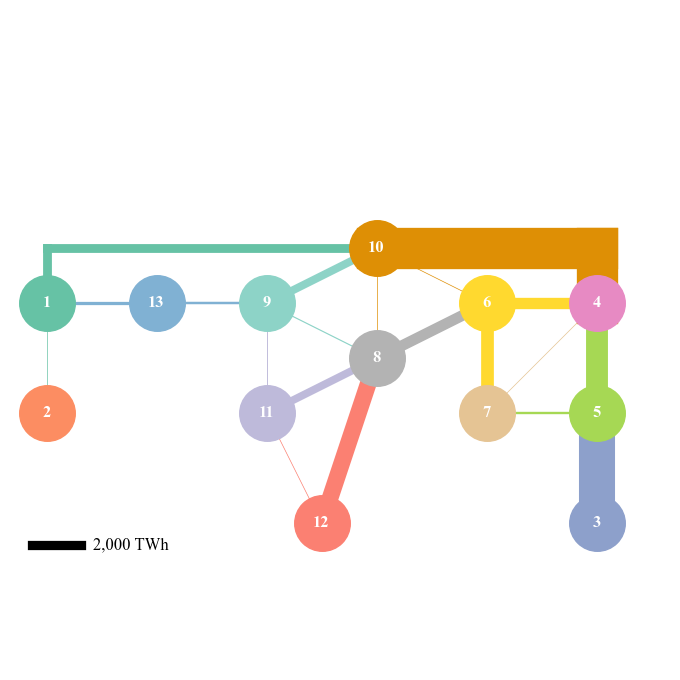

In [ ]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define coordinates for each region
coordinates = {
    "north_africa": (0, 0),
    "europe": (0, 1.5),
    "africa": (0.75, -1.5),
    "middle_east": (1.5, 0.75),
    "north_west_asia": (3, 1.5),
    "south_west_asia": (3, 0),
    "south_asia": (4.5, 0),
    "north_asia": (4.5, 1.5),
    "oceania": (4.5, -1.5),
    "ups": (1.5, 2.25),
    "atlantic_north": (-1.5, 1.5),
    "north_america": (-3, 1.5),  
    "latin_america": (-3, 0)
}

# Calculate total flow and share values
total_flow = sum(netflows_links.values())
share_values = [netflows_links[key] / total_flow for key in netflows_links]

# Scale coordinates to fit the plot
scale = 1.5  # Adjust the scale to fit within 6.6x6.6 inch plot
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}
arrow_colors = {value['name']: netflows_links[key] for key, value in links_dic.items()}

# Plotting the network without background map
fig, ax = plt.subplots(figsize=(6.6, 6.6))
plt.rc("font", size=12)

ax.set_xlim(-3.5 * scale, 5.5 * scale)
ax.set_ylim(-3.5 * scale, 5.5 * scale)

# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue
    ax.scatter(x, y, s=1600, color=region_colors[region_key_matched], zorder=5)  # Increased node size
    region_name = region_key.replace('_', ' ').title()
    region_number = regions_dic[region_key]['bus']
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_number, color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold')

# Plot lines
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    if bus0 is None or bus1 is None:
        print('Region key is none')
        continue
    
    flow = arrow_colors[value['name']]
    linewidth = max(np.abs(flow) / 0.3e9, 0.5)

    color = region_colors.get(bus0 if flow_statements[key] else bus1, 'grey')

    if key == "1_10":
        ax.plot([-3 * scale, -3 * scale], [1.5 * scale, 2.25 * scale], color=color, linewidth=linewidth)
        ax.plot([-3 * scale, 1.5 * scale], [2.25 * scale, 2.25 * scale], color=color, linewidth=linewidth)
    elif key == "4_10":
        ax.plot([1.5 * scale, 4.5 * scale], [2.25 * scale, 2.25 * scale], color=color, linewidth=linewidth)
        ax.plot([4.5 * scale, 4.5 * scale], [2.25 * scale, 1.5 * scale], color=color, linewidth=linewidth)
    else:
        ax.plot([scaled_coordinates[bus0][0], scaled_coordinates[bus1][0]], 
                [scaled_coordinates[bus0][1], scaled_coordinates[bus1][1]], color=color, linewidth=linewidth)

# Add a reference line for 2,000 TWh
reference_line_width = 2000e6 / 0.3e9  # Convert TWh to the same scale used for linewidth calculation
ax.plot([-3.2 * scale, -3.2 * scale + 1], [-1.8 * scale, -1.8 * scale], color='black', linewidth=reference_line_width)
ax.text(-3.1 * scale + 1.1, -1.8 * scale, '2,000 TWh', color='black', fontsize=12, va='center')

# Remove axes for a cleaner look
ax.set_axis_off()

# Adjust layout to remove extra whitespace
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Save figure with tight bounding box
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/flow-chart.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

plt.show()


# **Investigation of specific events**

## Curtailment and Net Flow in Atlantic North

In [ ]:
netflow_series = regions_dic['atlantic_north']['netflow_series']
max_netflow_value = netflow_series.max()
max_netflow_index = netflow_series.idxmax()
max_netflow_index

In [ ]:
# Assuming netflow_series is already defined as a pandas Series
curtailment_series = n.generators_t.p['curtailment_atlantic_north'] * 1e-3
netflow_series = regions_dic['atlantic_north']['netflow_series']
daily_netflow = netflow_series.groupby(netflow_series.index.date).sum()
demand_series_north_asia = n.loads_t.p_set['load_north_asia']
daily_demand_north_asia = demand_series_north_asia.groupby(demand_series_north_asia.index.date).sum()
# Plotting the series as a scatter plot
plt.figure(figsize=(10, 6))
#plt.scatter(difference.index, difference.values, label='Netflow', color='blue', s=5)
#plt.scatter(curtailment_series.index, curtailment_series.values, label='Curtailment', color='red', s=5)
plt.plot(netflow_series.index, netflow_series.values, label='Netflow', color='red', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Netflow')
plt.title('Netflow Series for Atlantic North')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Assuming netflow_series is already defined as a pandas Series
curtailment_series = n.generators_t.p['curtailment_atlantic_north'] * 1e-3
netflow_series = regions_dic['atlantic_north']['netflow_series']
daily_netflow = netflow_series.groupby(netflow_series.index.date).sum()
demand_series_north_asia = n.loads_t.p_set['load_north_asia']
daily_demand_north_asia = demand_series_north_asia.groupby(demand_series_north_asia.index.date).sum()
# Plotting the series as a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(demand_series_north_asia.index, demand_series_north_asia.values, label='Demand North Asia', color='blue')
plt.xlabel('Time')
plt.ylabel('Netflow')
plt.title('Netflow Series for Atlantic North')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Availability of VRE**

# Temporal availability

## Scatter plot of supply over demand 

In [ ]:
demand = 0
supply = 0
for key, value in regions_dic.items():
    demand += n.loads_t.p[f'load_{key}'] * 1e-3 #GW
    supply += (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}']) * 1e-3 
demand_supply_ratio = supply / demand
demand_supply_ratio_no_trans = pd.read_csv('demand_supply_ratio.csv', index_col=0)
fig, ax = plt.subplots(figsize=(5,3.5))
ax.scatter(demand_supply_ratio.index, demand_supply_ratio.values, s=0.3, color='brown', alpha=0.3)
ax.scatter(demand_supply_ratio.index, demand_supply_ratio_no_trans.values, s=0.3, color='blue', alpha=0.3)
ax.axhline(y=1, color='green', linewidth=1, linestyle='--')
ax.grid(False)
ax.set_ylabel('(-)', fontsize=12)
#ax.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# **Curtailment**

## Scatter plot global

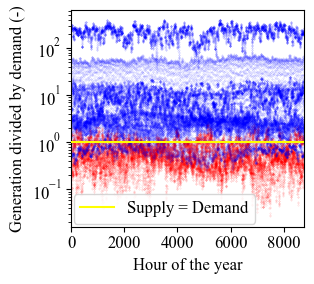

85.85996955859969 91.36415525114155


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

net_importer = ['north_asia', 'south_west_asia', 'europe']
net_exporter = ['oceania', 'north_west_asia', 'north_africa', 'atlantic_north', 'africa', 'north_america']
demand_net_importer = 0 
supply_net_importer = 0
demand_net_exporter = 0
supply_net_exporter = 0


#share_ex = (demand_supply_ratio_ex > 1).sum() / 8760 * 100
share_im = 0
fig, ax = plt.subplots(figsize=(3.3, 3))
for key in net_importer:
    demand_net_importer = n.loads_t.p[f'load_{key}'] 
    supply_net_importer = (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}'])
    demand_supply_ratio_im = supply_net_importer / demand_net_importer
    scatter_im = ax.scatter(demand_supply_ratio_im.index, demand_supply_ratio_im.values, s=0.07, color='red', alpha=0.2)
    share_im += (demand_supply_ratio_im < 1).sum() / 8760 * 100
share_im = share_im / len(net_importer)
share_ex = 0
for key in net_exporter:
    demand_net_exporter = n.loads_t.p[f'load_{key}'] 
    supply_net_exporter = (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}'])
    demand_supply_ratio_ex = supply_net_exporter / demand_net_exporter
    scatter_ex = ax.scatter(demand_supply_ratio_ex.index, demand_supply_ratio_ex.values, s=0.07, color='blue', alpha=0.2)
    share_ex += (demand_supply_ratio_ex > 1).sum() / 8760 * 100
share_ex = share_ex / len(net_exporter)
ax.axhline(y=1, color='yellow', linewidth=1.5, linestyle='-', label='Supply = Demand', zorder=10)

ax.grid(False)
ax.set_ylabel('Generation divided by demand (-)', fontsize=12)
ax.set_xlabel('Hour of the year')
ax.set_xlim(demand_supply_ratio_im.index[0], demand_supply_ratio_im.index[-1])
# Calculate the number of hours in the year and set x-ticks at every full 1000-hour interval
num_hours = len(demand_supply_ratio_im.index)
ticks_to_use = np.arange(0, num_hours, 2000)

# Extract the timestamps for the ticks
timestamps = demand_supply_ratio_im.index[ticks_to_use]

# Create labels as hours of the year
tick_labels = [str(i) for i in ticks_to_use]

ax.set_xticks(timestamps)
ax.set_xticklabels(tick_labels)
ax.set_yscale('log')
plt.tight_layout()
plt.legend(fontsize=12, frameon=True, loc='lower left', bbox_to_anchor=[-0.025, -0.025]) # handles=[scatter_im, scatter_ex], scatterpoints=1, markerscale=10,
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/scatter-plot.svg', format='svg')
plt.show()
print(share_im, share_ex)


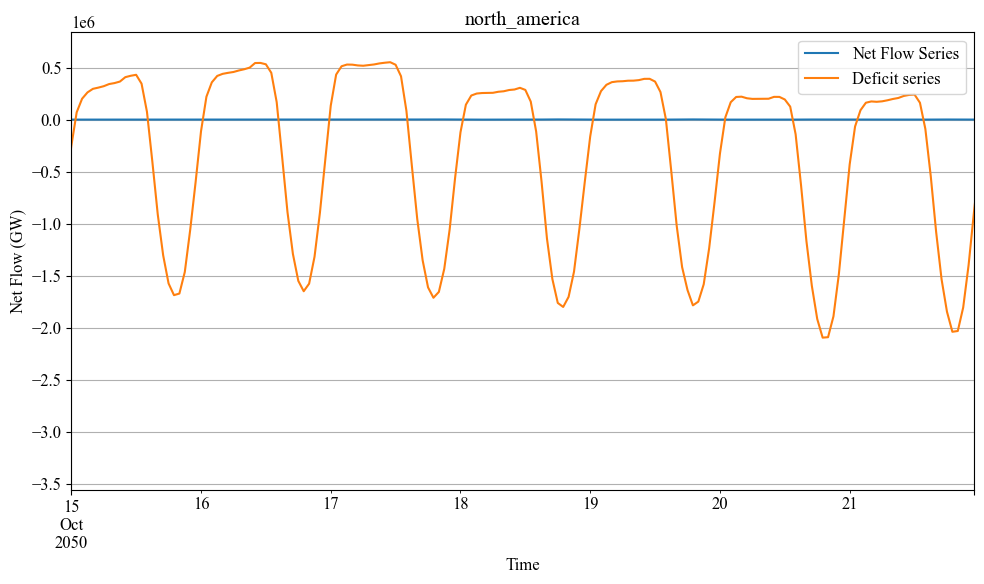

In [ ]:
na = ['north_america']
for key in na:
    demand_net_importer = n.loads_t.p[f'load_{key}'] 
    supply_net_importer = (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}'])
    series_netflow = regions_dic[f'{key}']['netflow_series']

series_deficit = demand_net_importer - supply_net_importer
plt.figure(figsize=(10, 6))
series_netflow.plot(label='Net Flow Series')
series_deficit.plot(label='Deficit series')
plt.title(f'{key}')
plt.xlabel('Time')
plt.ylabel('Net Flow (GW)')
plt.grid(True)
plt.xlim(pd.Timestamp('2050-10-15 00:00'), pd.Timestamp('2050-10-21 23:00'))
#plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
na = ['north_america']
for key in na:
    demand_net_importer = n.loads_t.p[f'load_{key}'] 
    supply_net_importer = (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}'])
    series_netflow = regions_dic[f'{key}']['netflow_series']

series_deficit = demand_net_importer - supply_net_importer
plt.figure(figsize=(10, 6))
series_netflow.plot(label='Net Flow Series')
series_deficit.plot(label='Net Flow Series')
plt.title(f'{key}')
plt.xlabel('Time')
plt.ylabel('Net Flow (GW)')
plt.grid(True)
plt.xlim(pd.Timestamp('2050-10-15 00:00'), pd.Timestamp('2050-10-21 23:00'))
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
tolerance = 1e-3 # tolerance for numerical inaccuracies
curtailment = 0
for key, value in regions_dic.items():
    curtailment +=  n.generators_t.p[f'curtailment_{key}'] * 1e-3 

fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(curtailment.index, curtailment.values, s=2, color=color_, alpha=0.6, label=f'{key}')

ax.set_xlabel('Time')
ax.set_ylabel('Curtailment')
ax.set_yscale('linear')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Scatter plot atlantic north

In [ ]:
# Graph
region = 'atlantic_north'
series = curtailment[region]
fig, ax = plt.subplots(figsize=(12,6))
color_ = region_colors[region]
ax.scatter(series.index, series.values, s=2, color=color_, alpha=0.6, label=f'{key}')

ax.set_xlabel('Time')
ax.set_ylabel('Supply over demand')
ax.set_yscale('linear')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))  
plt.plot(series.index, series.values, label='Curtailment', color='red', linewidth=1, linestyle='-', alpha=0.6)
plt.xlabel('Time', fontsize=16, fontweight='bold')  # Increase font size
plt.ylabel('MW', fontsize=16, fontweight='bold')  # Increase font size and add a more descriptive label
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)  # Move legend to upper left, increase font size, add frame and shadow
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to fit elements better
plt.show()
plt.show()

## Time series generation vs demand North Asia

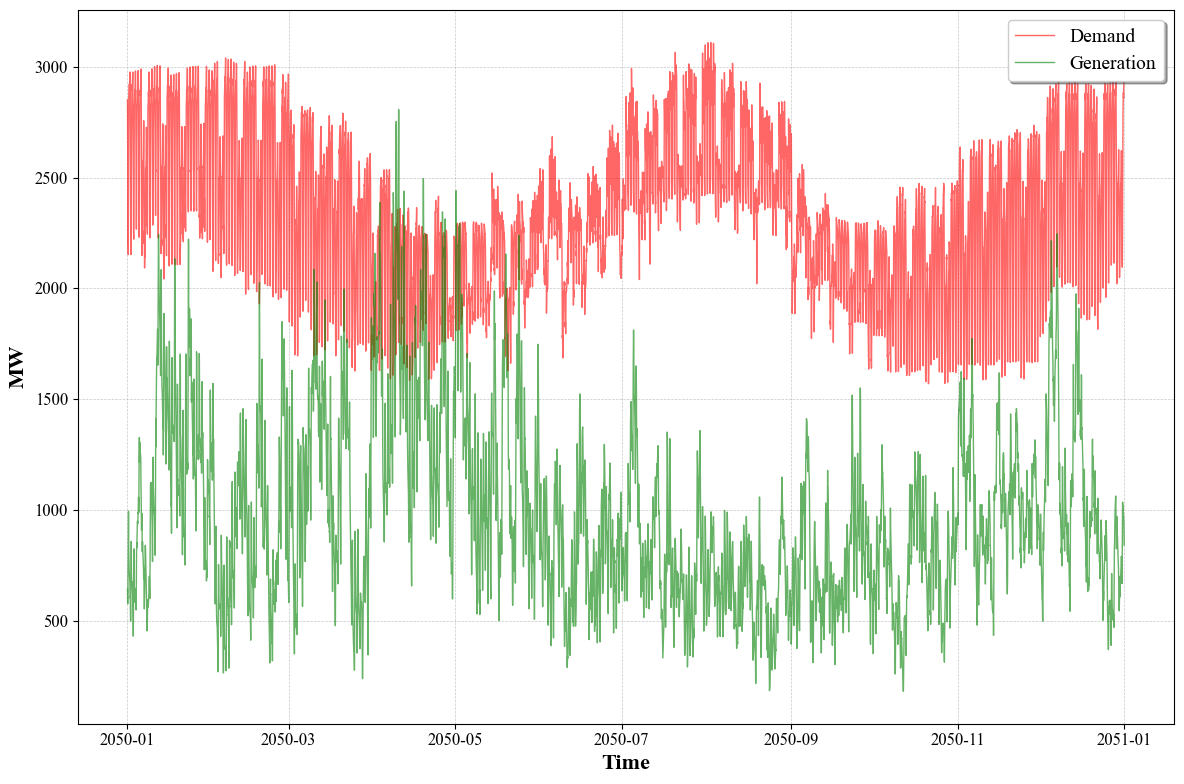

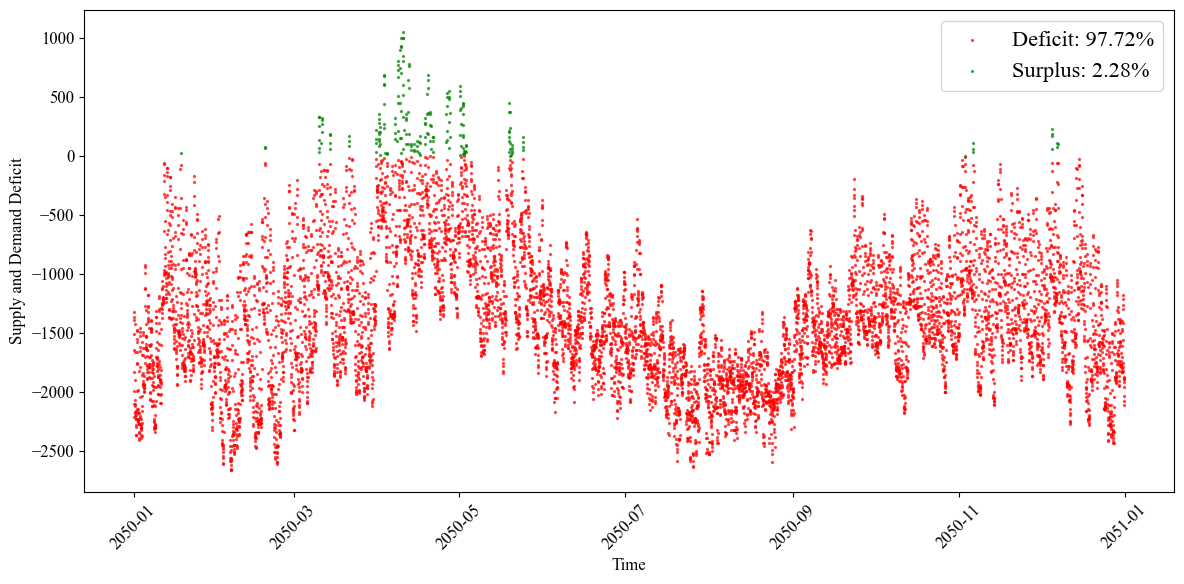

In [ ]:
demand_north_asia = n.loads_t.p[f'load_north_asia'] * 1e-3
gen_north_asia = (n.generators_t.p['wind_north_asia'] + n.generators_t.p['pv_north_asia']) * 1e-3
deficit = gen_north_asia - demand_north_asia

# Graph
plt.figure(figsize=(12, 8))  
plt.plot(demand_north_asia.index, demand_north_asia.values, label='Demand', color='red', linewidth=1, linestyle='-', alpha=0.6)
plt.plot(gen_north_asia.index, gen_north_asia.values, label='Generation', color='green', linewidth=1, linestyle='-', alpha=0.6)
plt.xlabel('Time', fontsize=16, fontweight='bold')  # Increase font size
plt.ylabel('MW', fontsize=16, fontweight='bold')  # Increase font size and add a more descriptive label
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)  # Move legend to upper left, increase font size, add frame and shadow
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to fit elements better
plt.show()
plt.show()

# scatter plot
# Calculate percentages
total_points = len(deficit)
points_above_zero = (deficit > 0).sum()
points_below_zero = (deficit <= 0).sum()

percentage_above_zero = (points_above_zero / total_points) * 100
percentage_below_zero = (points_below_zero / total_points) * 100

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot points below zero in red
ax.scatter(deficit[deficit <= 0].index, deficit[deficit <= 0].values, s=2, color='red', alpha=0.6, label=f'Deficit: {percentage_below_zero:.2f}%')

# Plot points above zero in green
ax.scatter(deficit[deficit > 0].index, deficit[deficit > 0].values, s=2, color='green', alpha=0.6, label=f'Surplus: {percentage_above_zero:.2f}%')

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Supply and Demand Deficit')
ax.set_yscale('linear')
ax.legend(fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Time series inflow north asia 

In [ ]:
inflow_north_asia = regions_dic['north_asia']['netflow_series']

# Graph
plt.figure(figsize=(12, 8))  
plt.plot(inflow_north_asia.index, inflow_north_asia.values, label='Net flow', color='red', linewidth=1, linestyle='-', alpha=0.6)
plt.xlabel('Time', fontsize=16, fontweight='bold')  # Increase font size
plt.ylabel('GW', fontsize=16, fontweight='bold')  # Increase font size and add a more descriptive label
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)  # Move legend to upper left, increase font size, add frame and shadow
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to fit elements better
plt.show()
plt.show()

## Fourier series generation vs demand North Asia

In [ ]:
# Convert to numpy array
hourly_p_trans_rel_gen_array = deficit.values

# Step 2: Perform Fourier Transform
# Number of sample points
N = len(hourly_p_trans_rel_gen_array)
# Sample spacing (assuming hourly data, so 1 hour)
T = 1.0

# Perform FFT
yf = fft(hourly_p_trans_rel_gen_array)
xf = fftfreq(N, T)[:N//2]
# Calculate the frequencies for 3-hour, 6-hour, 12-hour, daily, and weekly intervals
three_hour_freq = 1 / 3.0
six_hour_freq = 1 / 6.0
eight_hour_freq = 1 / 8.0
half_daily_freq = 1 / 12.0
daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)

frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq,half_daily_freq, daily_freq, weekly_freq]
labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
# Step 3: Plot the FFT results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# Set custom x-ticks and labels
ax.set_xticks(frequencies)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlim(-0.01, 1/5.5)

ax.set_xlabel('Frequency', fontweight='bold')
ax.set_ylabel('Amplitude', fontweight='bold')
ax.set_title(f'Fourier Transform of Supply vs Demand deficit', fontweight='bold')
ax.grid(True, axis='x')

plt.show()


## Fourier series inflow north asia

In [ ]:
# Convert to numpy array
hourly_p_trans_rel_gen_array = inflow_north_asia.values

# Step 2: Perform Fourier Transform
# Number of sample points
N = len(hourly_p_trans_rel_gen_array)
# Sample spacing (assuming hourly data, so 1 hour)
T = 1.0

# Perform FFT
yf = fft(hourly_p_trans_rel_gen_array)
xf = fftfreq(N, T)[:N//2]
# Calculate the frequencies for 3-hour, 6-hour, 12-hour, daily, and weekly intervals
three_hour_freq = 1 / 3.0
six_hour_freq = 1 / 6.0
eight_hour_freq = 1 / 8.0
half_daily_freq = 1 / 12.0
daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)

frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq,half_daily_freq, daily_freq, weekly_freq]
labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
# Step 3: Plot the FFT results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# Set custom x-ticks and labels
ax.set_xticks(frequencies)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlim(-0.01, 1/5.5)

ax.set_xlabel('Frequency', fontweight='bold')
ax.set_ylabel('Amplitude', fontweight='bold')
ax.set_title(f'Fourier Transform of Supply vs Demand deficit', fontweight='bold')
ax.grid(True, axis='x')

plt.show()

## Fourier series VRE potential atlantic north

In [ ]:
# Convert to numpy array
series = res_potential_dic['atlantic_north']['pv']
hourly_p_trans_rel_gen_array = series.values

# Step 2: Perform Fourier Transform
# Number of sample points
N = len(hourly_p_trans_rel_gen_array)
# Sample spacing (assuming hourly data, so 1 hour)
T = 1.0

# Perform FFT
yf = fft(hourly_p_trans_rel_gen_array)
xf = fftfreq(N, T)[:N//2]
# Calculate the frequencies for 3-hour, 6-hour, 12-hour, daily, and weekly intervals
three_hour_freq = 1 / 3.0
six_hour_freq = 1 / 6.0
eight_hour_freq = 1 / 8.0
half_daily_freq = 1 / 12.0
daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)

frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq,half_daily_freq, daily_freq, weekly_freq]
labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
# Step 3: Plot the FFT results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# Set custom x-ticks and labels
ax.set_xticks(frequencies)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlim(-0.01, 1/5.5)

ax.set_xlabel('Frequency', fontweight='bold')
ax.set_ylabel('Amplitude', fontweight='bold')
ax.set_title(f'Fourier Transform of Supply vs Demand deficit', fontweight='bold')
ax.grid(True, axis='x')

plt.show()

## Correlation Matrix of VRE potentials vs Demand 

In [ ]:
data1 = pd.DataFrame({key: res_potential_dic[key]['pv'] for i, (key, value) in enumerate(regions_dic.items())})
data2 = pd.DataFrame({key: res_potential_dic[key]['wind'] for i, (key, value) in enumerate(regions_dic.items())})
demand = pd.DataFrame({key: load_profile_dic[key]['load'] for i, (key, value) in enumerate(regions_dic.items())})


regions = data1.columns

# Create empty correlation matrices
correlation_matrix1 = pd.DataFrame(index=regions, columns=regions)
correlation_matrix2 = pd.DataFrame(index=regions, columns=regions)

# Fill the correlation matrices
for i in regions:
    for j in regions:
        correlation_matrix1.loc[i, j] = data1[i].corr(demand[j])
        correlation_matrix2.loc[i, j] = data2[i].corr(demand[j])

# Plot the correlation matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for data1
ax1 = axes[0]
cax1 = ax1.matshow(correlation_matrix1.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax1.set_xticks(range(len(correlation_matrix1.columns)))
ax1.set_yticks(range(len(correlation_matrix1.index)))
ax1.set_xticklabels(correlation_matrix1.columns, rotation=45, ha='left', fontsize=12)
ax1.set_yticklabels(correlation_matrix1.index, fontsize=12)
ax1.set_title('Correlation Matrix: Solar and Demand', fontsize=14, fontweight='bold', pad=20)
ax1.grid(False)

# Add text annotations
for i in range(len(correlation_matrix1.columns)):
    for j in range(len(correlation_matrix1.index)):
        ax1.text(i, j, f'{correlation_matrix1.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')

# Plot for data2
ax2 = axes[1]
cax2 = ax2.matshow(correlation_matrix2.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax2.set_xticks(range(len(correlation_matrix2.columns)))
ax2.set_yticks(range(len(correlation_matrix2.index)))
ax2.set_xticklabels(correlation_matrix2.columns, rotation=45, ha='left', fontsize=12)
ax2.set_yticklabels(correlation_matrix2.index, fontsize=12)
ax2.set_title('Correlation Matrix: Wind and Demand', fontsize=14, fontweight='bold', pad=20)
ax2.grid(False)

# Add text annotations
for i in range(len(correlation_matrix2.columns)):
    for j in range(len(correlation_matrix2.index)):
        ax2.text(i, j, f'{correlation_matrix2.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')


plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming res_potential_dic and load_profile_dic are already defined as dictionaries

# Create DataFrames for PV, wind, and demand
data1 = pd.DataFrame({key: res_potential_dic[key]['pv'] for i, (key, value) in enumerate(regions_dic.items())})
data2 = pd.DataFrame({key: res_potential_dic[key]['wind'] for i, (key, value) in enumerate(regions_dic.items())})
demand = pd.DataFrame({key: load_profile_dic[key]['load'] for i, (key, value) in enumerate(regions_dic.items())})

regions = data1.columns

# Create empty correlation matrices
correlation_matrix1 = pd.DataFrame(index=regions, columns=regions)
correlation_matrix2 = pd.DataFrame(index=regions, columns=regions)

# Fill the correlation matrices
for i in regions:
    for j in regions:
        adjusted_demand_j = demand[j] - demand[i]
        correlation_matrix1.loc[i, j] = data1[i].corr(adjusted_demand_j)
        correlation_matrix2.loc[i, j] = data2[i].corr(adjusted_demand_j)

# Plot the correlation matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for data1
ax1 = axes[0]
cax1 = ax1.matshow(correlation_matrix1.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax1.set_xticks(range(len(correlation_matrix1.columns)))
ax1.set_yticks(range(len(correlation_matrix1.index)))
ax1.set_xticklabels(correlation_matrix1.columns, rotation=45, ha='left', fontsize=12)
ax1.set_yticklabels(correlation_matrix1.index, fontsize=12)
ax1.set_title('Correlation Matrix: Solar and Adjusted Demand', fontsize=14, fontweight='bold', pad=20)
ax1.grid(False)

# Add text annotations
for i in range(len(correlation_matrix1.columns)):
    for j in range(len(correlation_matrix1.index)):
        ax1.text(i, j, f'{correlation_matrix1.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')

# Plot for data2
ax2 = axes[1]
cax2 = ax2.matshow(correlation_matrix2.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax2.set_xticks(range(len(correlation_matrix2.columns)))
ax2.set_yticks(range(len(correlation_matrix2.index)))
ax2.set_xticklabels(correlation_matrix2.columns, rotation=45, ha='left', fontsize=12)
ax2.set_yticklabels(correlation_matrix2.index, fontsize=12)
ax2.set_title('Correlation Matrix: Wind and Adjusted Demand', fontsize=14, fontweight='bold', pad=20)
ax2.grid(False)

# Add text annotations
for i in range(len(correlation_matrix2.columns)):
    for j in range(len(correlation_matrix2.index)):
        ax2.text(i, j, f'{correlation_matrix2.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming res_potential_dic and load_profile_dic are already defined as dictionaries

# Create DataFrames for PV, wind, and demand
data1 = pd.DataFrame({key: res_potential_dic[key]['pv'] for i, (key, value) in enumerate(regions_dic.items())})
data2 = pd.DataFrame({key: res_potential_dic[key]['wind'] for i, (key, value) in enumerate(regions_dic.items())})
demand = pd.DataFrame({key: load_profile_dic[key]['load'] for i, (key, value) in enumerate(regions_dic.items())})
generation = pd.DataFrame({key: n.generators_t.p[f'wind_{key}'] for i, (key, value) in enumerate(regions_dic.items())})
regions = list(regions_dic.keys())
num_regions = len(regions)

# Initialize the R-squared matrix
r_squared_matrix = np.zeros((num_regions, num_regions))

# Loop through each region's demand and each region's PV and wind
for i, region_demand in enumerate(regions):

    for j, region_generation in enumerate(regions):
        y = demand[region_demand].values - demand[region_generation].values
        X = np.vstack([data1[region_generation].values, data2[region_generation].values, data1[region_demand].values, data2[region_demand].values]).T
        model = LinearRegression().fit(X, y)
        r_squared = model.score(X, y)
        r_squared_matrix[j, i] = r_squared

# Convert R-squared matrix to DataFrame for better readability
r_squared_df = pd.DataFrame(r_squared_matrix, index=regions, columns=regions)

# Plot the R-squared matrix
fig, ax = plt.subplots(figsize=(6.6, 6.6))

# Display the matrix values with reversed colormap
cax = ax.matshow(r_squared_df, cmap='PuBu', vmin=0, vmax=1)
index = r_squared_df.columns
labels = [label.replace('_', ' ').title() for label in index]
# Set axis ticks and labels
ax.grid(False)
ax.set_xticks(range(len(r_squared_df.columns)))
ax.set_yticks(range(len(r_squared_df.index)))
ax.set_xticklabels(labels, rotation=45, fontsize=12, ha='left')
ax.set_yticklabels(labels, fontsize=12)

# Add text annotations
for i in range(len(r_squared_df.columns)):
    for j in range(len(r_squared_df.index)):
        if i != j:
            plt.text(i, j, f'{r_squared_df.iloc[j, i]:.2f}', ha='center', va='center', color= 'black', fontsize=12, fontweight='bold')

# Title and layout adjustments
#plt.title('R-squared Matrix: PV & Wind Generation vs. Demand', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/correlation-matrix-vre-demand.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()


# Comparison to alternative energy carriers

## DAC

In [ ]:
dac_demand_gj = 1.3 # GJ/tCO2 # https://www.iea.org/energy-system/carbon-capture-utilisation-and-storage/direct-air-capture
gj_to_gwh = 2.78E-04 
dac_demand_gwh = dac_demand_gj * gj_to_gwh # GWh/tCO2
global_demand_co2_removal = 80 # MtCO2 per year
global_dac_demand_gwh = dac_demand_gwh * global_demand_co2_removal * 1e6
print(f'{global_dac_demand_gwh:.2e}')
print(f'{total_annual_cur*1e-3:.2e}')

## Hydrogen

In [ ]:
global_h2_demand_2050 = 585 # Mt # net zero scenario # https://www.mckinsey.com/industries/oil-and-gas/our-insights/global-energy-perspective-2023-hydrogen-outlook
h2_demand_kWh = 55 #kWh/kg # https://www.mdpi.com/2071-1050/15/24/16917
h2_demand_GWh = h2_demand_kWh * 1e3 # GWh/Mt
global_h2_demand_gwh = h2_demand_GWh * global_h2_demand_2050
print(f'{global_h2_demand_gwh:.2e}')

## Desalination

In [ ]:
desalination_energy_kWh_m3 = 2.5 # kWh/m3 # https://www.amtaorg.com/wp-content/uploads/07_Membrane_Desalination_Power_Usage_Put_In_Perspective.pdf
annual_desalination_water_l = total_annual_cur / desalination_energy_kWh_m3 * 1e3
daily_desalination_water_l = annual_desalination_water_l / 365
print(f'{daily_desalination_water_l:.2e}')



## Agriculture

In [ ]:
greenhouse_intensity_GJ_ha = 13000 #GJ/ha in GER (tomatoes)#https://www.mdpi.com/2076-3417/12/10/5150#:~:text=Most%20energy%20consumption%20is%20associated,of%20the%20total%20fossil%20sources).
yield_tomato = 50 # kg/m2
ha_to_m2 = 1e-4 
greenhouse_intensity_GWh_ha = greenhouse_intensity_GJ_ha * gj_to_gwh 
greenhouse_intensity_GWh_m2 = greenhouse_intensity_GWh_ha * ha_to_m2
greenhouse_intensity_GWh_kg = greenhouse_intensity_GWh_m2 * yield_tomato
tomato_cap_Mt = total_annual_cur *1e-3 / greenhouse_intensity_GWh_kg * 1e-3
print(f'{tomato_cap_Mt:.2e} tons')



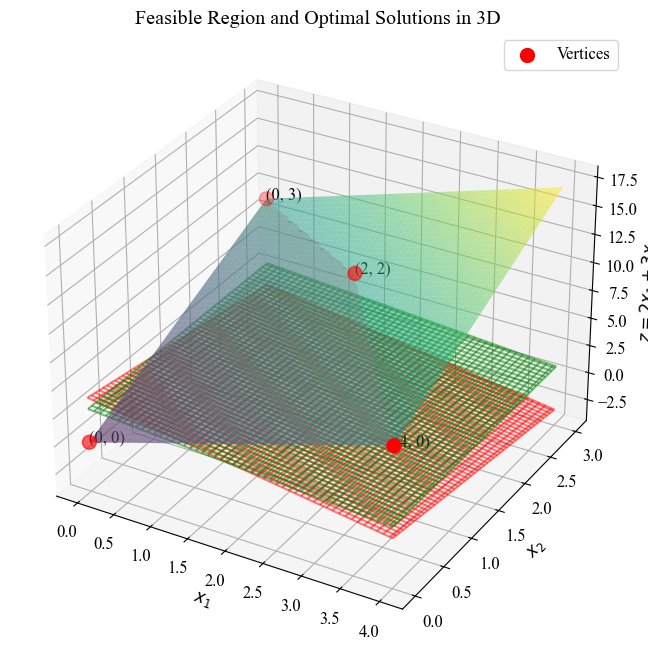

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a mesh grid for x1 and x2
x1 = np.linspace(0, 4, 100)
x2 = np.linspace(0, 3, 100)
x1, x2 = np.meshgrid(x1, x2)
z = 2 * x1 + 3 * x2  # Objective function

# Constraints
constraint1 = 4 - x1 - x2
constraint2 = (6 - x1) / 2

# Feasible region mask
feasible_mask = (x1 + x2 <= 4) & (x1 + 2 * x2 <= 6)

# Vertices of the feasible region
vertices = np.array([[0, 0], [0, 3], [2, 2], [4, 0]])
z_vertices = 2 * vertices[:, 0] + 3 * vertices[:, 1]

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the objective function surface
ax.plot_surface(x1, x2, z, alpha=0.5, cmap='viridis')

# Plot the constraints as wireframes
ax.plot_wireframe(x1, x2, constraint1, color='r', alpha=0.5)
ax.plot_wireframe(x1, x2, constraint2, color='g', alpha=0.5)

# Highlight the feasible region
feasible_z = np.where(feasible_mask, z, np.nan)
ax.plot_surface(x1, x2, feasible_z, alpha=0.3, color='grey')

# Plot vertices and optimal solutions
ax.scatter(vertices[:, 0], vertices[:, 1], z_vertices, color='red', s=100, label='Vertices')

# Annotate the vertices
for (i, vert) in enumerate(vertices):
    ax.text(vert[0], vert[1], z_vertices[i], f'({vert[0]}, {vert[1]})', fontsize=12)

# Labels and title
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$z = 2x_1 + 3x_2$')
ax.set_title('Feasible Region and Optimal Solutions in 3D')
ax.legend()

plt.show()
